# About the data

This project is based on data provided by HELP International, an international humanitarian NGO dedicated to fighting poverty and providing essential relief and basic amenities to people in underdeveloped and disaster-affected countries.

Recently, HELP International has successfully raised $10 million in funding and now aims to strategically allocate these resources to countries that are in the most urgent need of aid. To support this decision-making process, we have access to a dataset containing various socio-economic and health indicators for multiple countries.

# What we are going to do

The primary goal of this project is to:

Cluster countries based on key socio-economic and health factors that influence overall development.

Identify groups of countries with similar development profiles using unsupervised learning (clustering) techniques.

Recommend the countries that are in greatest need of HELP International’s aid and intervention.

# Install the requird libraries

In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler , MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN ,  MeanShift , estimate_bandwidth
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from yellowbrick.cluster import KElbowVisualizer
from scipy.cluster.hierarchy import dendrogram, linkage


import warnings
warnings.filterwarnings('ignore')

# Load and explore the data

In [2]:
data = pd.read_csv("Country-data.csv")

In [3]:
data.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


Some information about the dataset

In [4]:
information = pd.read_csv("data-dictionary.csv")
for i in range(information.shape[0]):
    print(information.iloc[i][0],'--->',information.iloc[i][1])


country ---> Name of the country
child_mort ---> Death of children under 5 years of age per 1000 live births
exports ---> Exports of goods and services per capita. Given as %age of the GDP per capita
health ---> Total health spending per capita. Given as %age of GDP per capita
imports ---> Imports of goods and services per capita. Given as %age of the GDP per capita
Income ---> Net income per person
Inflation ---> The measurement of the annual growth rate of the Total GDP
life_expec ---> The average number of years a new born child would live if the current mortality patterns are to remain the same
total_fer ---> The number of children that would be born to each woman if the current age-fertility rates remain the same.
gdpp ---> The GDP per capita. Calculated as the Total GDP divided by the total population.


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [6]:
data.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


They are not in the same range so we want to scale them later

In [7]:
data.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

In [8]:
data.duplicated().sum()

0

We dont have any missing or duplicated data so our data is clear

In [9]:
print("Number of unique countries:", data['country'].nunique())
print("Total rows:", len(data))

Number of unique countries: 167
Total rows: 167


# Exploratory Data Analysis (EDA)

In [10]:
numerical_values = data.iloc[:,1:].columns

In [11]:
len(numerical_values)

9

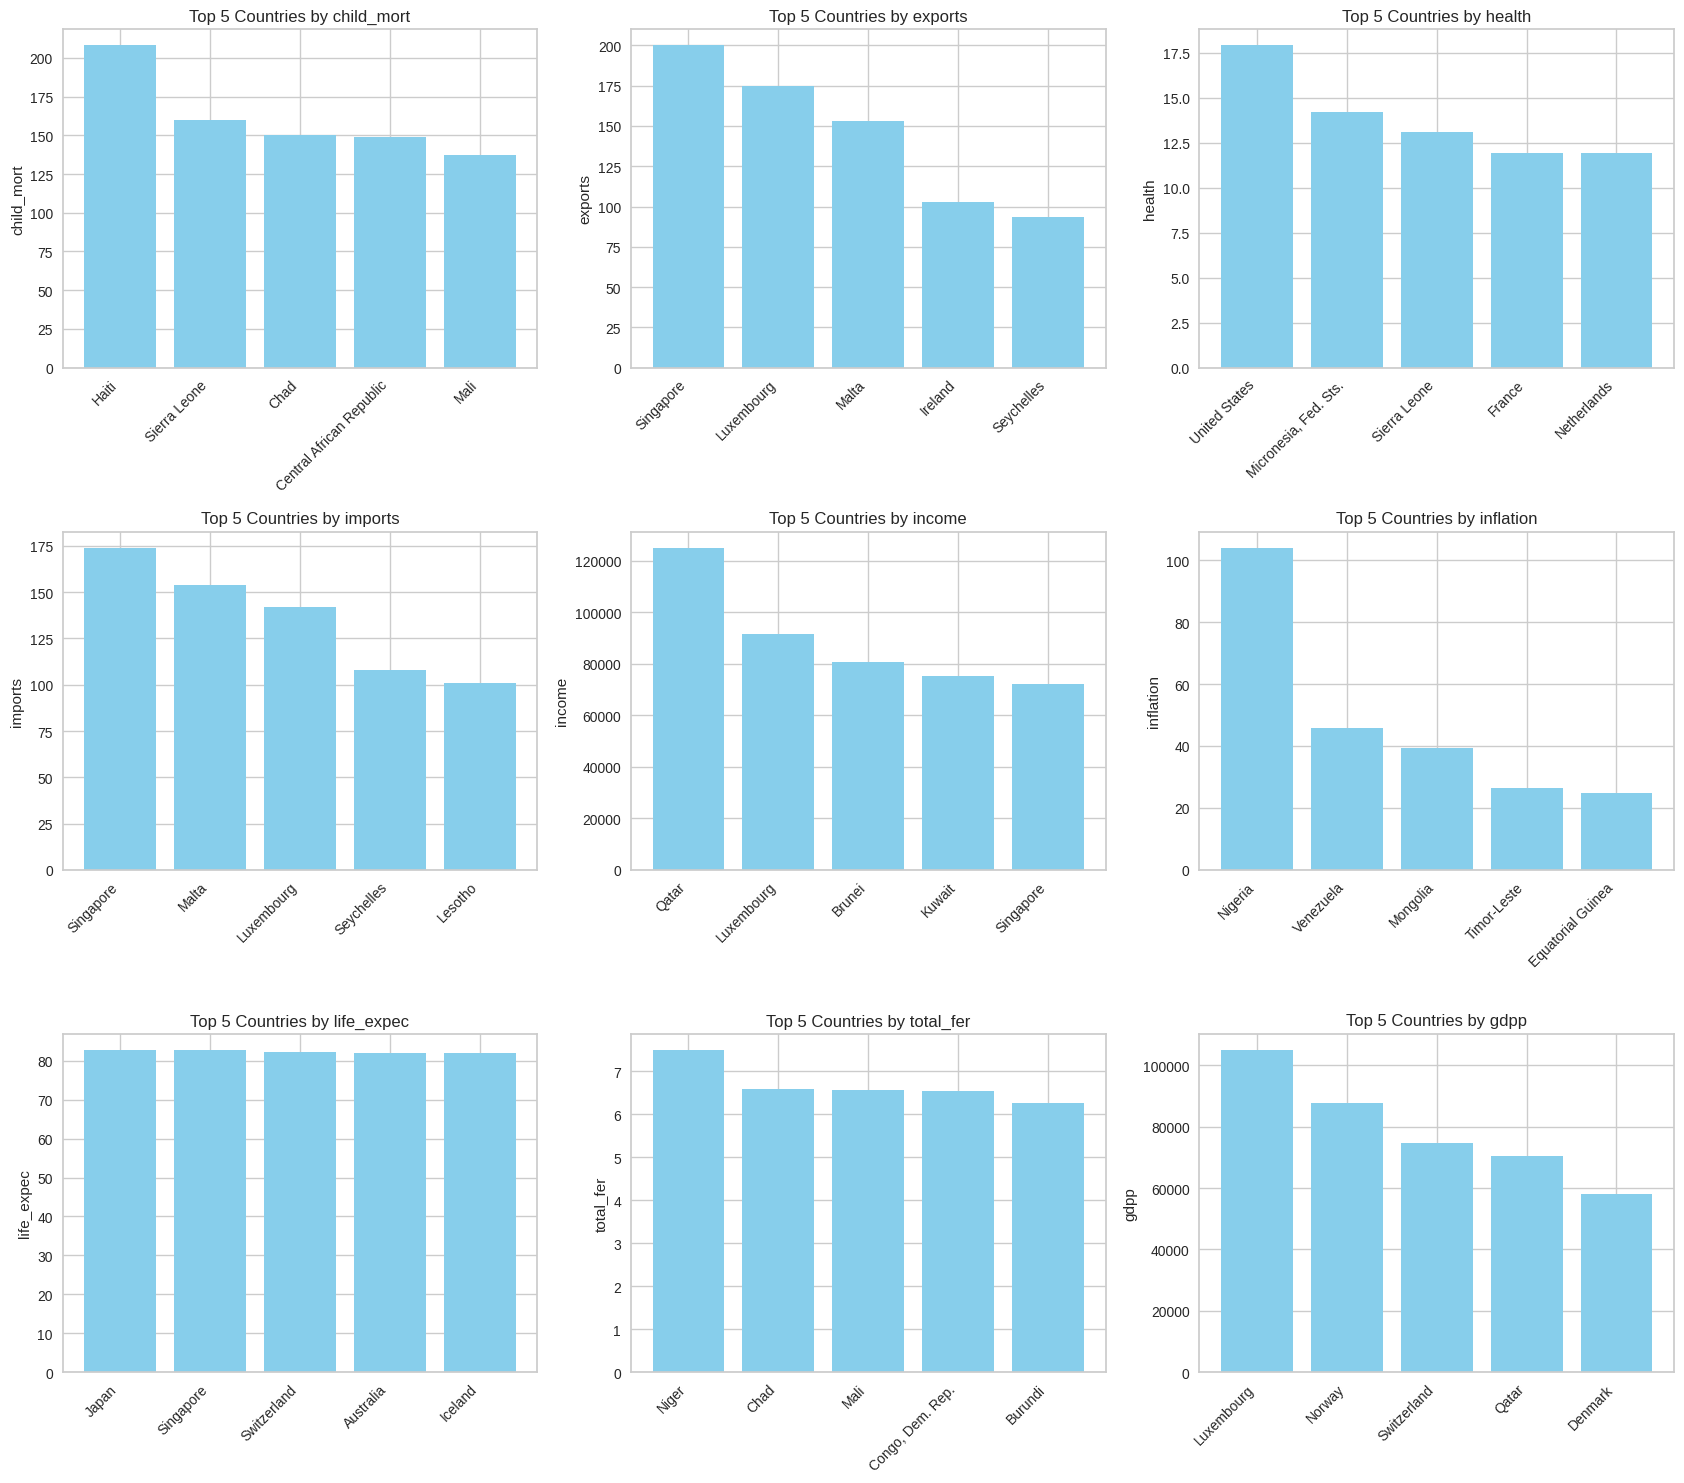

In [12]:
fig, axes = plt.subplots(3, 3, figsize=(17, 15))
axes = axes.flatten()
for idx, i in enumerate(numerical_values):
    top5 = data.nlargest(5, i)
    ax = axes[idx]
    ax.bar(top5['country'], top5[i], color='skyblue')
    ax.set_title(f'Top 5 Countries by {i}', fontsize=12)
    ax.set_ylabel(i)
    ax.set_xticklabels(top5['country'], rotation=45, ha='right')
plt.tight_layout()
plt.show()

Countries such as Haiti, Chad, Mali, Sierra Leone, and Niger consistently appear in high-risk categories ( high child mortality, high fertility, low life expectancy, high inflation).

These might be prioritized for aid based on the combination of poor health outcomes, low income, and unstable economic indicators.

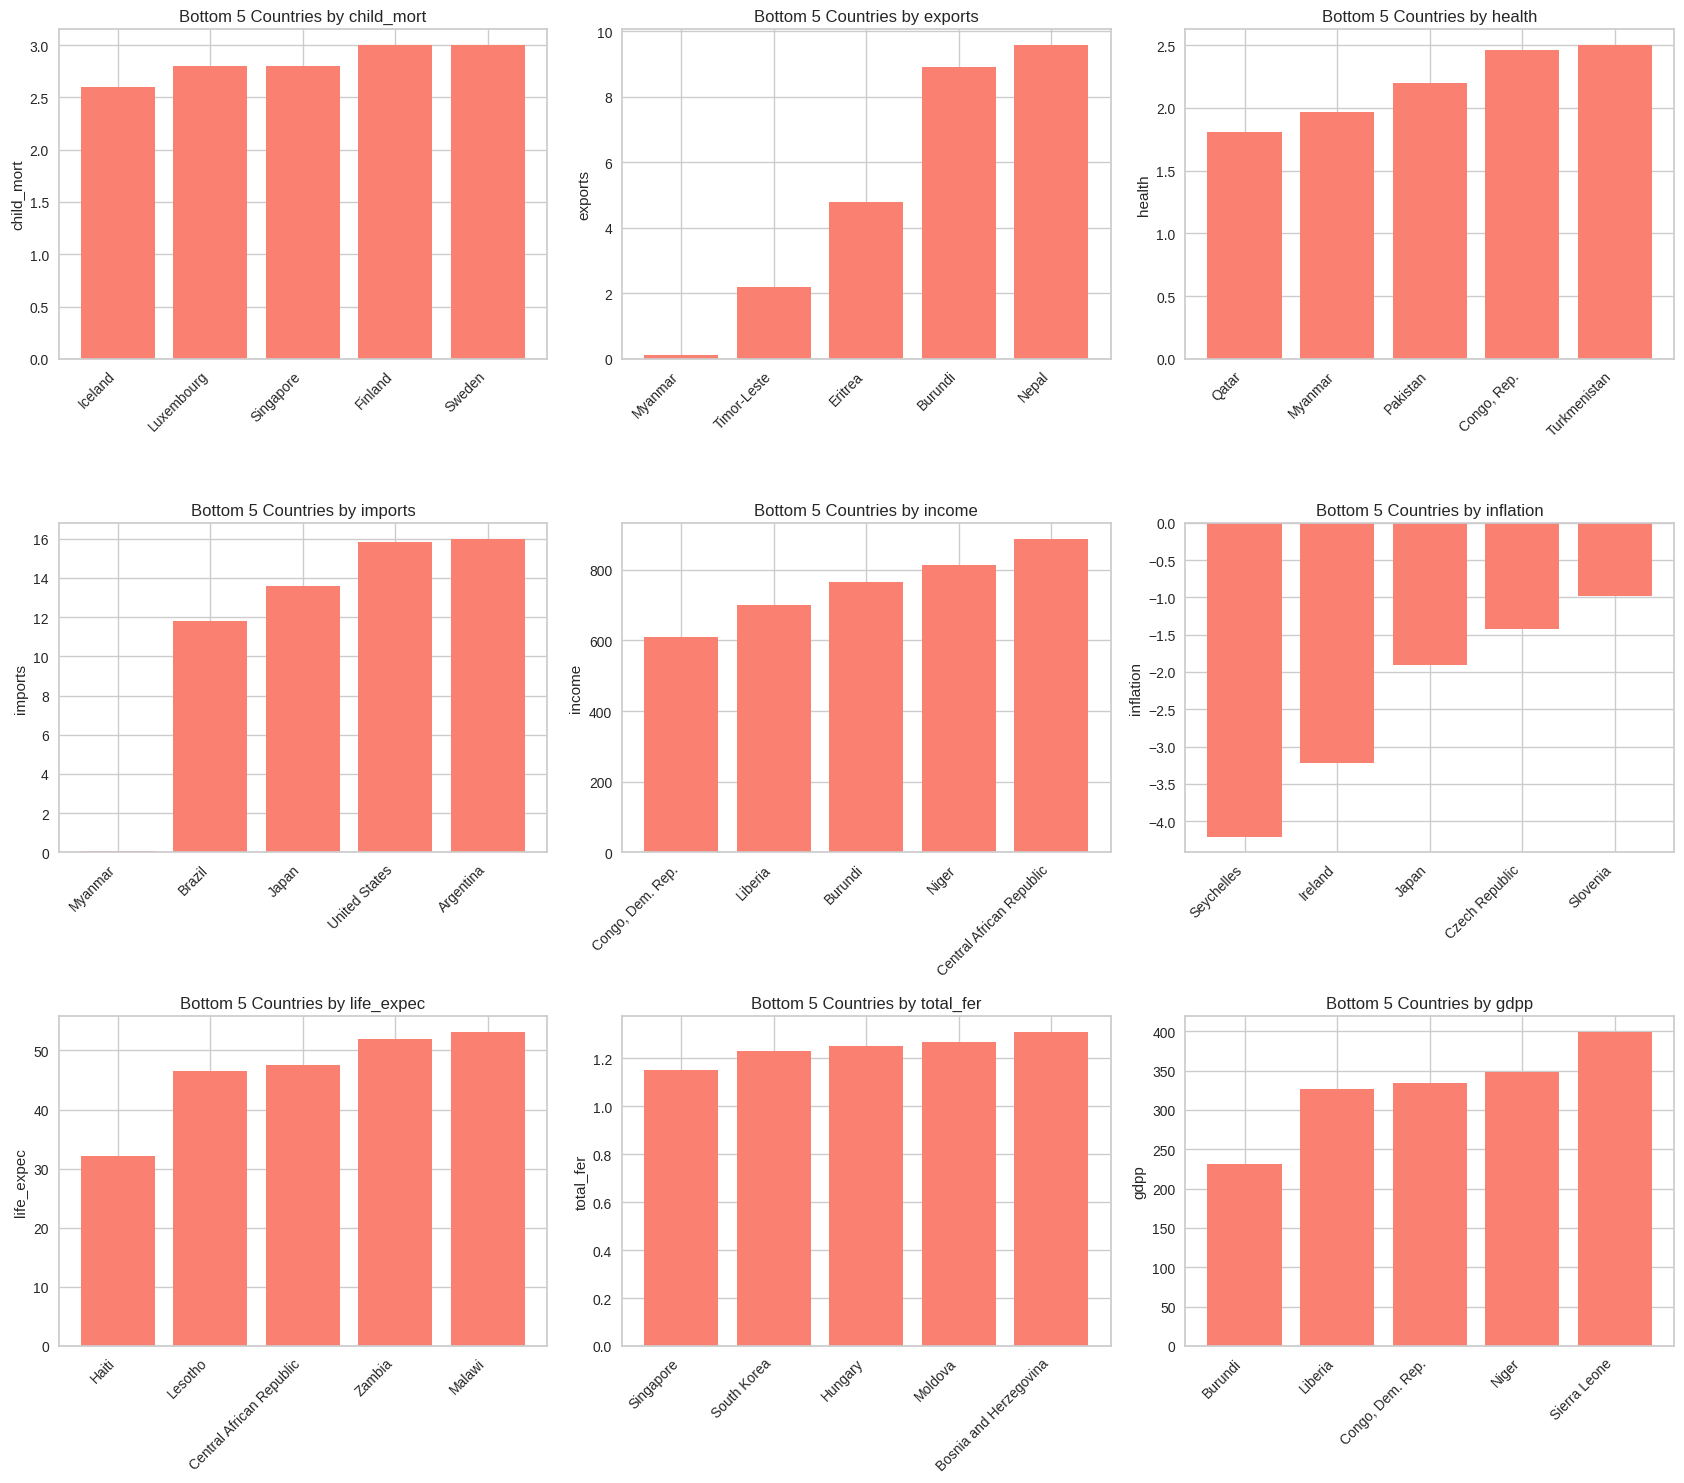

In [13]:

fig, axes = plt.subplots(3, 3, figsize=(17, 15))
axes = axes.flatten()

for idx, i in enumerate(numerical_values):
    bottom5 = data.nsmallest(5, i)
    ax = axes[idx]
    ax.bar(bottom5['country'], bottom5[i], color='salmon')
    ax.set_title(f'Bottom 5 Countries by {i}', fontsize=12)
    ax.set_ylabel(i)
    ax.set_xticklabels(bottom5['country'], rotation=45, ha='right')

plt.tight_layout()
plt.show()


| Country                  | Appears in Bottom 5 For                     |
| ------------------------ | ------------------------------------------- |
| **Haiti**                | Child Mortality, Life Expectancy, Inflation |
| **Burundi**              | GDP, Income                                 |
| **Niger**                | Income, Fertility                           |
| **Central African Rep.** | Life Expectancy, Income                     |
| **Chad**                 | Health, Fertility                           |


These countries show up consistently across multiple high-risk indicators, making them strong candidates for HELP International’s funding and aid.

Exploring the outliers

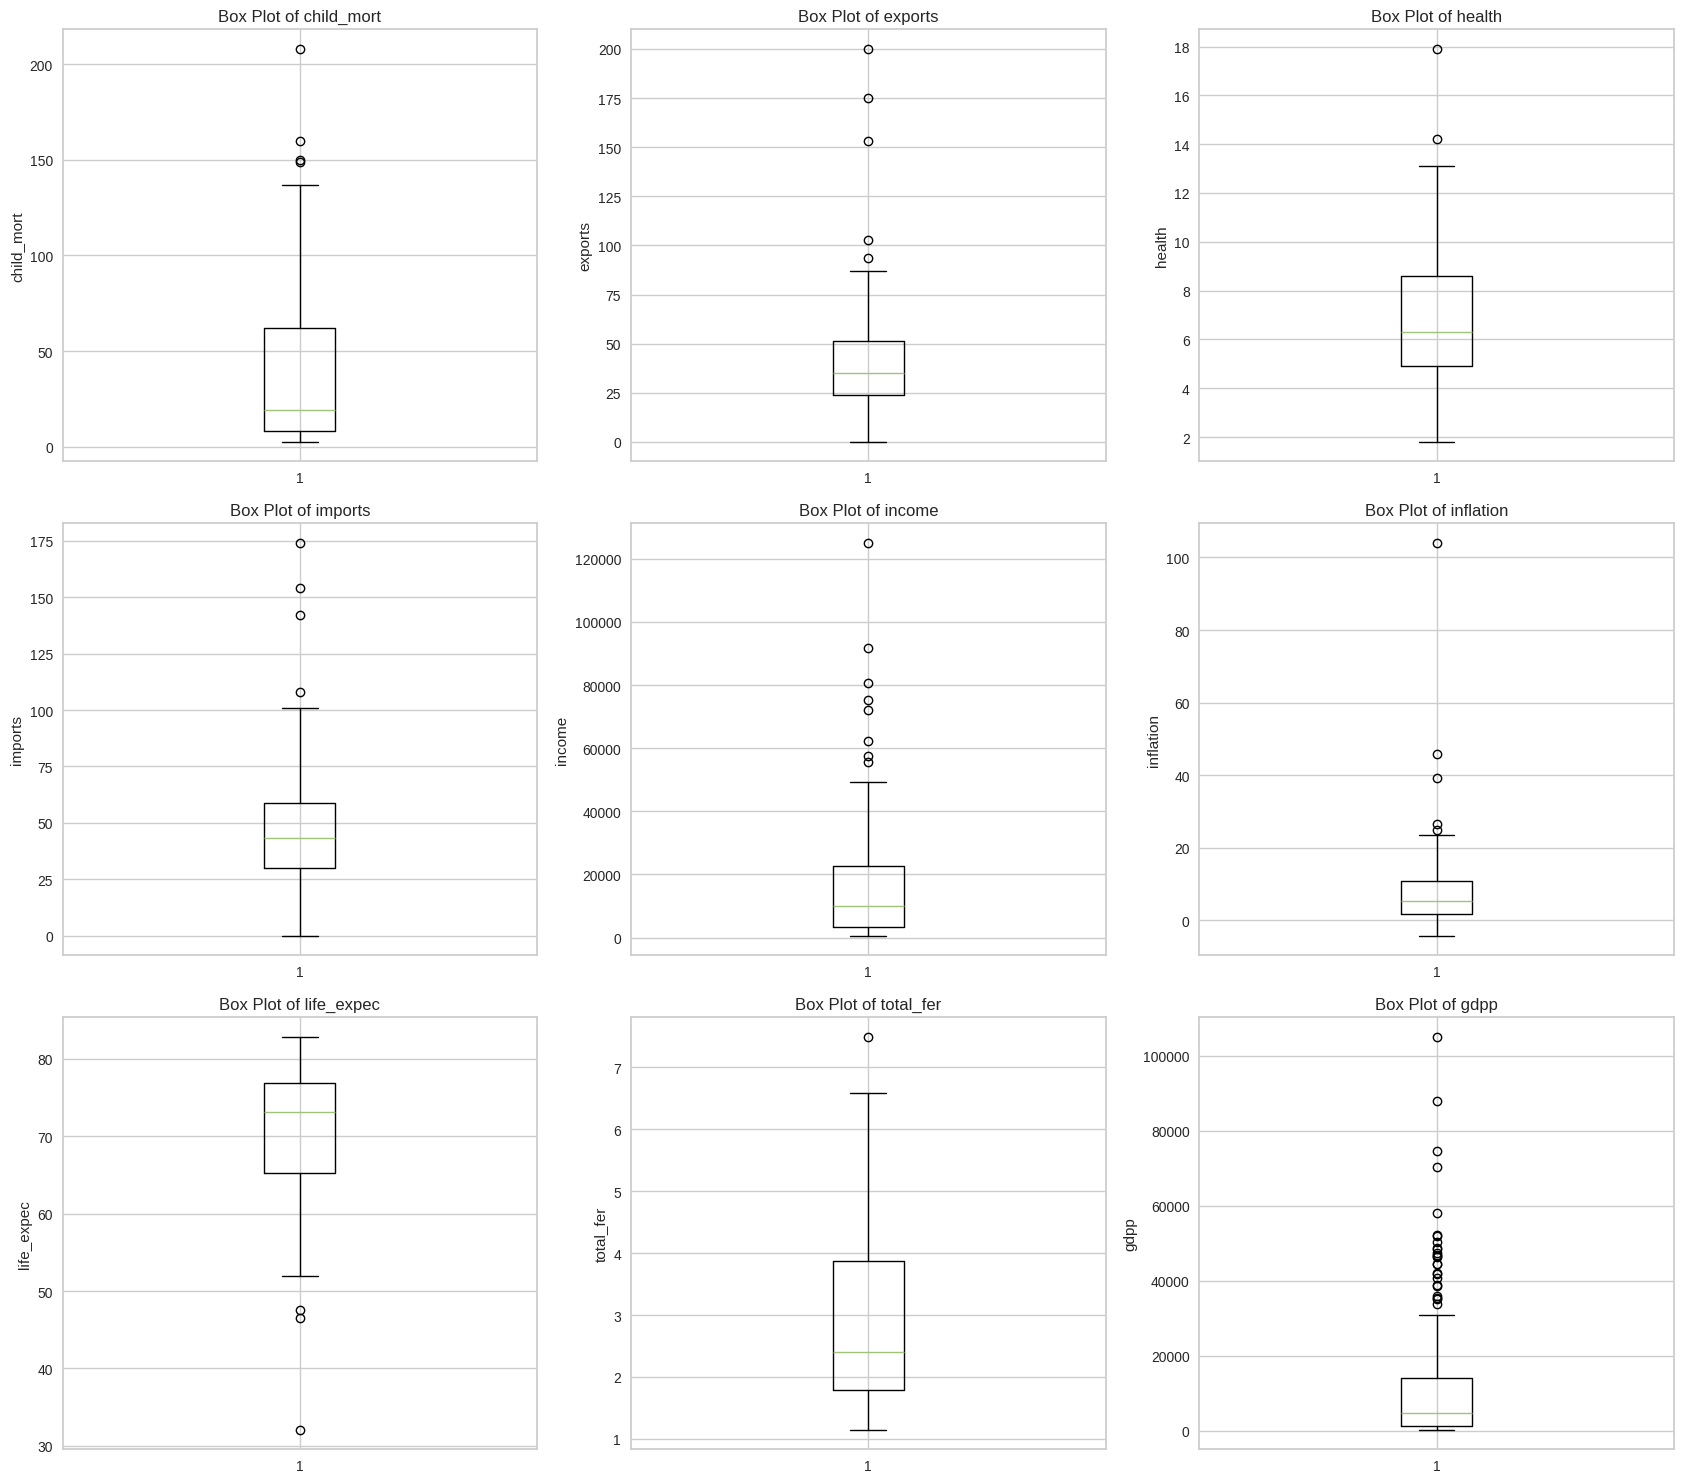

In [14]:
fig, axes = plt.subplots(3, 3, figsize=(17, 15))
axes = axes.flatten()
for idx, col in enumerate(numerical_values):
    ax = axes[idx]
    ax.boxplot(data[col])
    ax.set_title(f'Box Plot of {col}')
    ax.set_ylabel(col)

plt.tight_layout()
plt.show()

as we can notice that we have many outliers and based on this we will use models that deal with the outliers 

# Correlation and Skwness

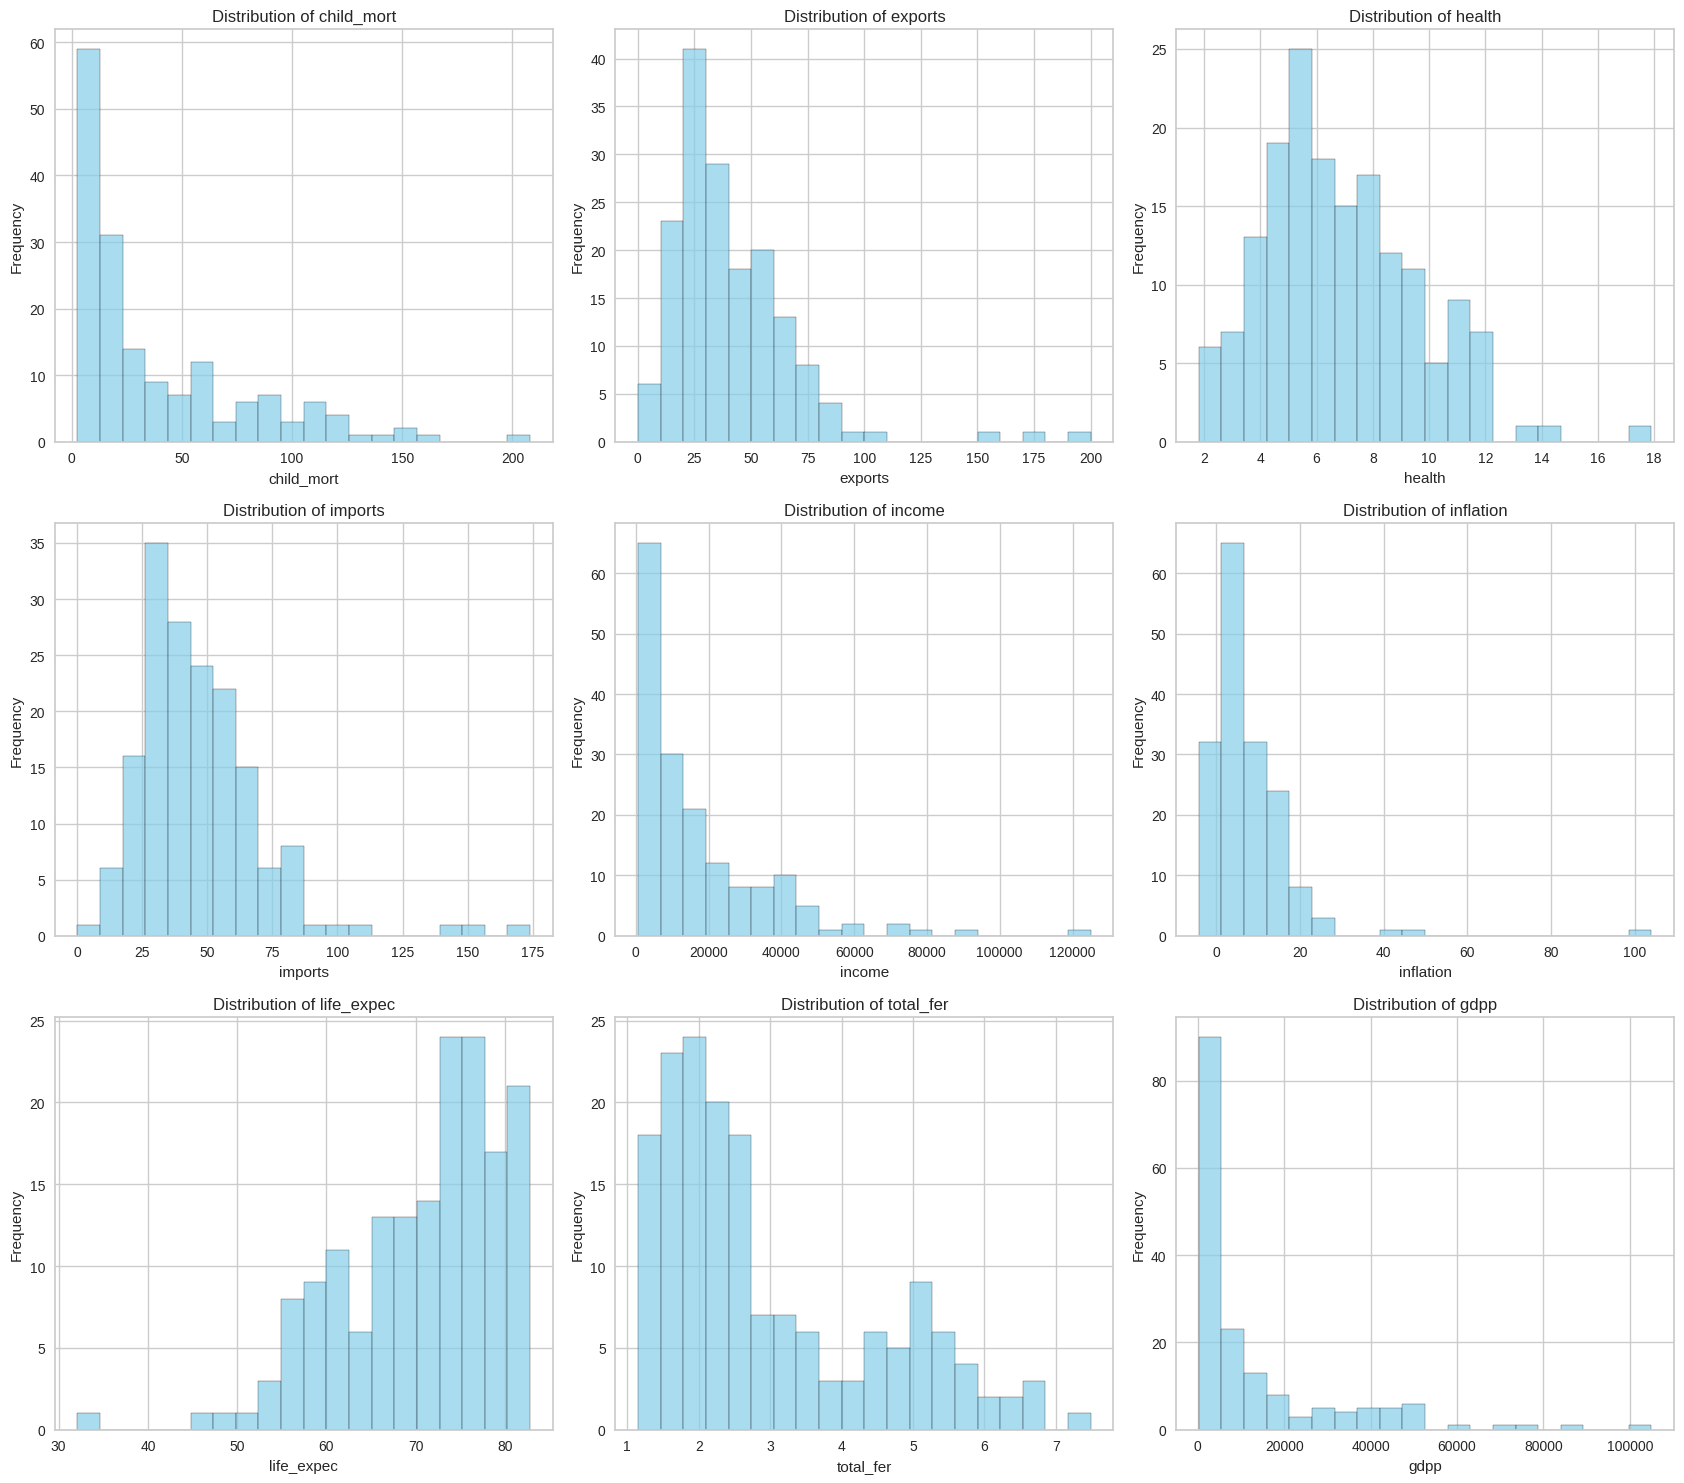

In [15]:
fig, axes = plt.subplots(3, 3, figsize=(17, 15))
axes = axes.flatten()

for idx, col in enumerate(numerical_values):
    ax = axes[idx]
    ax.hist(data[col], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [16]:

print("Skewness of each variable:")
for col in numerical_values:
    skewness = data[col].skew()
    print(f"{col}: {skewness:.3f}")



Skewness of each variable:
child_mort: 1.451
exports: 2.446
health: 0.706
imports: 1.905
income: 2.231
inflation: 5.154
life_expec: -0.971
total_fer: 0.967
gdpp: 2.218


many of them are skewed lets see the correlation 


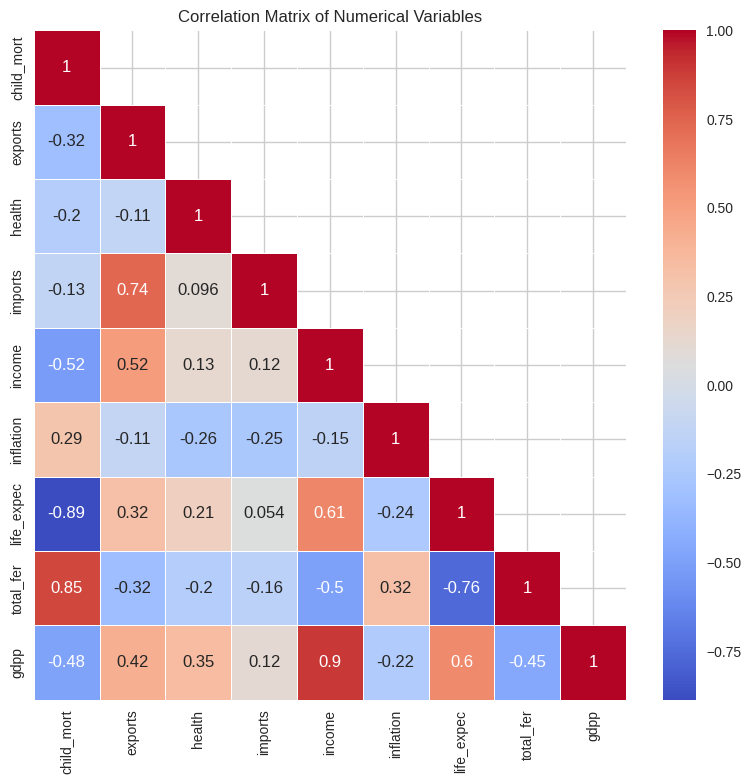

In [17]:
plt.figure(figsize=(8, 8))
correlation_matrix = data[numerical_values].corr()
for i in range(len(numerical_values)):
    for j in range(len(numerical_values)):
        if i < j: 
            correlation_matrix.iloc[i, j] = np.nan

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', 
            linewidths=0.5)
plt.title('Correlation Matrix of Numerical Variables')
plt.tight_layout()
plt.show()

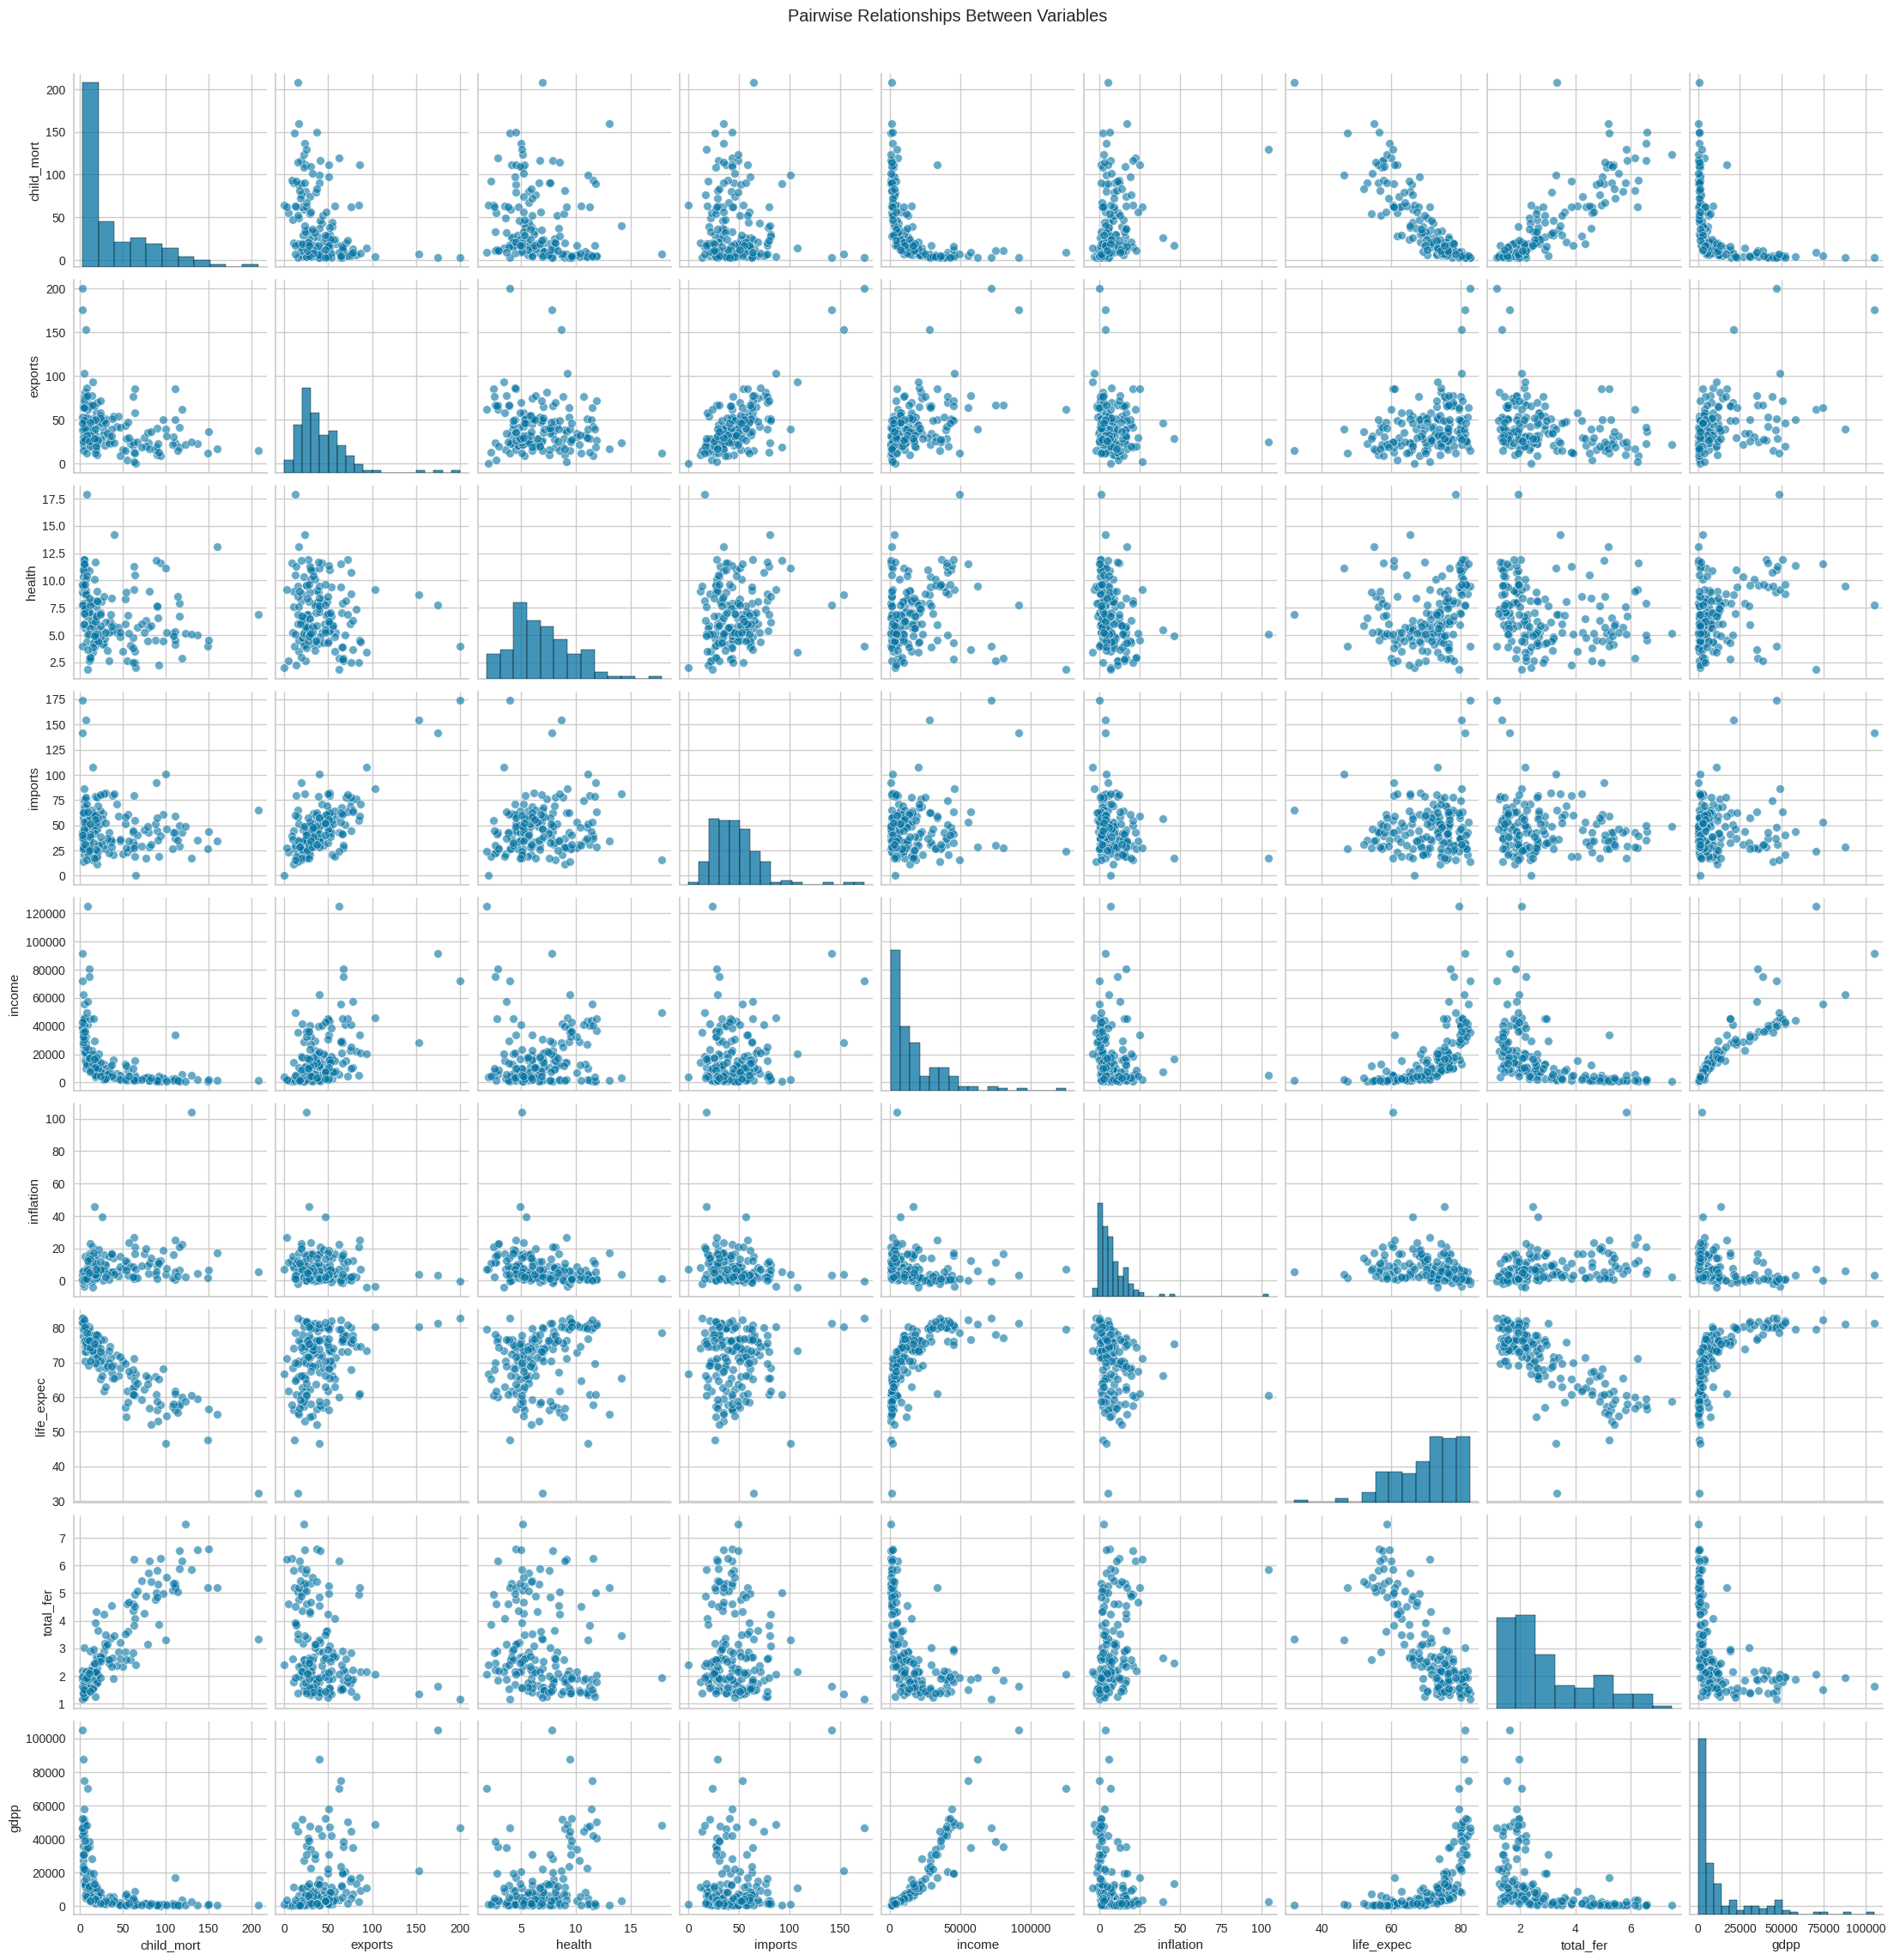

In [18]:
sns.pairplot(data[numerical_values], diag_kind='hist', plot_kws={'alpha': 0.6})
plt.suptitle('Pairwise Relationships Between Variables', y=1.02)
plt.show()

# Scaling 

Based on our data i am going to use normalization an all columns expect health because they are not normally distributed and "Health" is Normally Distributed

In [ ]:
data_scaled = data.copy().drop("country", axis = 1)
Sc = StandardScaler()
mm = MinMaxScaler()

numerical_without_health = [c for c in numerical_values if c != "health"]
for i in numerical_without_health:
    data_scaled[i] = mm.fit_transform(data_scaled[[i]])

data_scaled["health"] = Sc.fit_transform(data_scaled[["health"]])

data_scaled


,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,0.426485,0.049482,0.279088,0.257765,0.008047,0.126144,0.475345,0.736593,0.003073
1,0.068160,0.139531,-0.097016,0.279037,0.074933,0.080399,0.871795,0.078864,0.036833
2,0.120253,0.191559,-0.966073,0.180149,0.098809,0.187691,0.875740,0.274448,0.040365
3,0.566699,0.311125,-1.448071,0.246266,0.042535,0.245911,0.552268,0.790221,0.031488
4,0.037488,0.227079,-0.286894,0.338255,0.148652,0.052213,0.881657,0.154574,0.114242
...,...,...,...,...,...,...,...,...,...
162,0.129503,0.232582,-0.571711,0.302609,0.018820,0.063118,0.609467,0.370662,0.026143
163,0.070594,0.142032,-0.695862,0.100809,0.127750,0.463081,0.854043,0.208202,0.126650
164,0.100779,0.359651,0.008877,0.460715,0.031200,0.150725,0.808679,0.126183,0.010299
165,0.261441,0.149536,-0.597272,0.197397,0.031120,0.257000,0.698225,0.555205,0.010299


In [22]:
data_scaled.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,1.670000e+02,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,0.173661,0.205112,5.504579e-16,0.269207,0.132933,0.110820,0.758495,0.283591,0.121536
std,0.196343,0.137135,1.003008e+00,0.139188,0.154980,0.097687,0.175408,0.238777,0.174944
min,0.000000,0.000000,-1.827827e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.027507,0.118520,-6.922106e-01,0.173250,0.022076,0.055633,0.654832,0.101735,0.010490
50%,0.081305,0.174550,-1.810007e-01,0.248566,0.075174,0.088716,0.808679,0.198738,0.042274
75%,0.289679,0.256345,6.515412e-01,0.337393,0.178397,0.138250,0.881657,0.430599,0.131900
max,1.000000,1.000000,4.047436e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [23]:
mean = data_scaled.describe().loc['mean',:] 
mean

child_mort    1.736614e-01
exports       2.051117e-01
health        5.504579e-16
imports       2.692072e-01
income        1.329332e-01
inflation     1.108200e-01
life_expec    7.584948e-01
total_fer     2.835905e-01
gdpp          1.215355e-01
Name: mean, dtype: float64

# Apply PCA

In [24]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_fitted = pca.fit_transform(data_scaled)

In [25]:
pca_data = pd.DataFrame(data=pca_fitted, columns=['PC1', 'PC2'])

In [26]:
pca_data

,PC1,PC2
0,0.220482,0.640048
1,-0.080903,-0.172000
2,-0.961283,-0.125199
3,-1.505914,0.472144
4,-0.264724,-0.237308
...,...,...
162,-0.584662,0.089055
163,-0.689176,-0.151368
164,0.012693,-0.123744
165,-0.628317,0.259154


In [27]:
pca.explained_variance_ratio_.sum()*100

93.00284585106176

Text(0, 0.5, 'PC2')

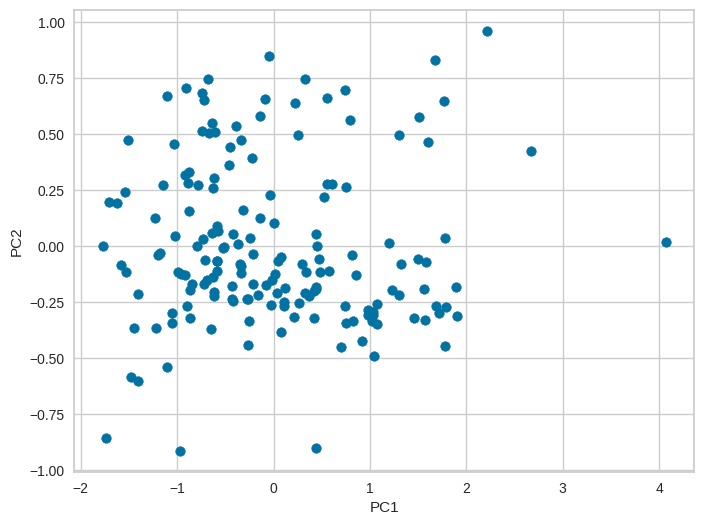

In [28]:
plt.figure(figsize=(8,6))

plt.scatter(pca_data['PC1'], pca_data['PC2'])
plt.xlabel("PC1")
plt.ylabel("PC2")

# Apply Clustering Without PCA

I am going to apply various clustering algorithms like ( K-Means, Hierarchical Clustering, DBSCAN, and Mean Shift algorithms)

In [29]:
data_copy = data.copy()

# K-means

In [ ]:
def optimal_clusters(Data, knumber):
    inertia = []
    silhouette_scores = []
    for n in range(1, knumber + 1):  
        kmeans = KMeans(n_clusters=n, init='k-means++', random_state=42, n_init=10)
        kmeans.fit(Data)
        inertia.append(kmeans.inertia_)
        if(n != 1) :
            silhouette_scores.append(silhouette_score(Data, kmeans.labels_))

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    ax1 = axes[0]
    ax1.plot(range(1, knumber + 1), inertia, marker='o')
    ax1.set_title("Elbow Method")
    ax1.set_xlabel("Number of Clusters")
    ax1.set_ylabel("Inertia")

    ax2 = axes[1]
    ax2.plot(range(2, knumber + 1), silhouette_scores, marker='o', color='b', linestyle='--')
    ax2.set_title("Silhouette Scores")
    ax2.set_xlabel("Number of Clusters")
    ax2.set_ylabel("Silhouette Score")

    plt.tight_layout()
    plt.show()

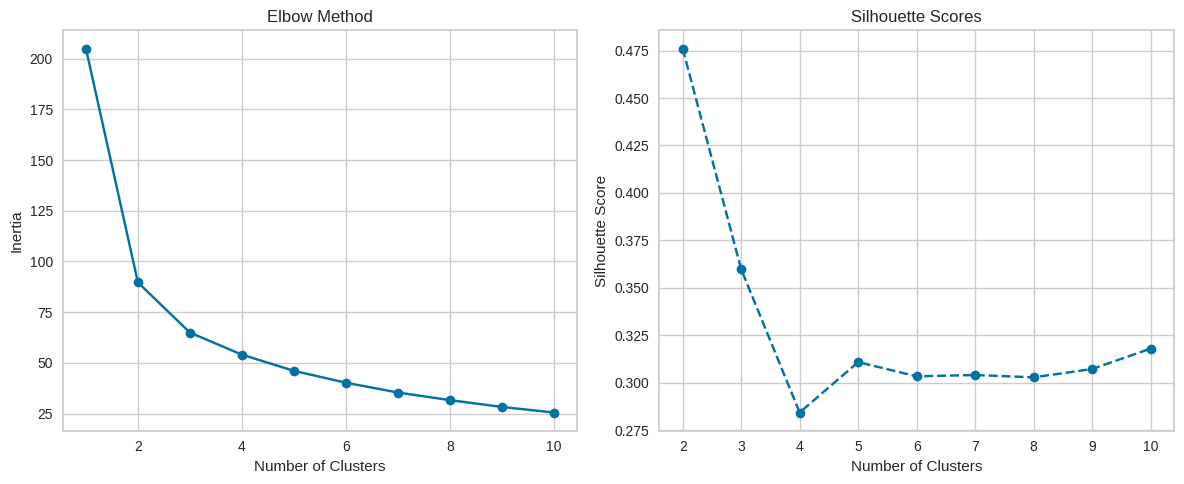

In [120]:
optimal_clusters(data_scaled, 10)

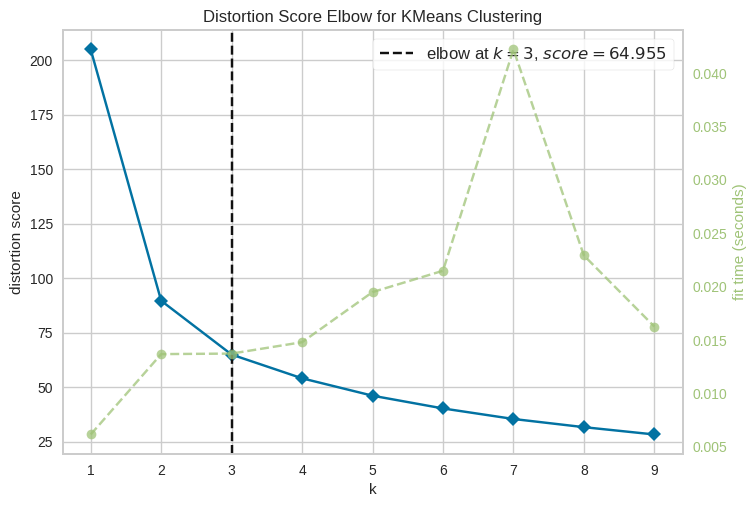

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [121]:
Kmean = KMeans(init='k-means++', n_init=10, random_state=42)
elbovis = KElbowVisualizer(Kmean ,k = (1,10))
elbovis.fit(data_scaled)
elbovis.show()

So from these figures we can say that 3 clusters would be a good choice

In [122]:
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42, n_init=10)
kmeans.fit(data_scaled)

KMeans(n_clusters=3, n_init=10, random_state=42)

In [123]:
kmean_labels = kmeans.labels_
data_copy["kmean_labels"] = kmean_labels

In [124]:
kmean_labels

array([2, 2, 1, 1, 2, 2, 1, 2, 0, 1, 2, 1, 1, 2, 1, 0, 1, 1, 1, 1, 0, 2,
       2, 1, 2, 2, 0, 1, 1, 0, 1, 1, 1, 2, 1, 2, 1, 2, 1, 0, 1, 2, 2, 2,
       0, 2, 2, 1, 2, 1, 1, 2, 1, 2, 0, 1, 1, 0, 0, 1, 0, 1, 2, 1, 2, 1,
       2, 2, 0, 1, 1, 1, 2, 0, 2, 0, 1, 0, 2, 1, 1, 0, 1, 2, 1, 2, 2, 0,
       0, 1, 2, 2, 2, 1, 2, 1, 2, 1, 2, 1, 2, 0, 0, 1, 2, 1, 1, 1, 2, 1,
       0, 0, 1, 1, 0, 1, 1, 2, 1, 1, 1, 2, 0, 1, 1, 1, 0, 2, 1, 1, 0, 1,
       0, 1, 2, 0, 2, 2, 2, 0, 1, 1, 2, 2, 0, 0, 1, 1, 1, 2, 2, 1, 2, 2,
       1, 2, 2, 1, 0, 0, 2, 1, 1, 1, 2, 1, 1], dtype=int32)

In [125]:
pd.value_counts(kmean_labels)

1    76
2    58
0    33
Name: count, dtype: int64

#  Hierarchical Agglomerative Clustering

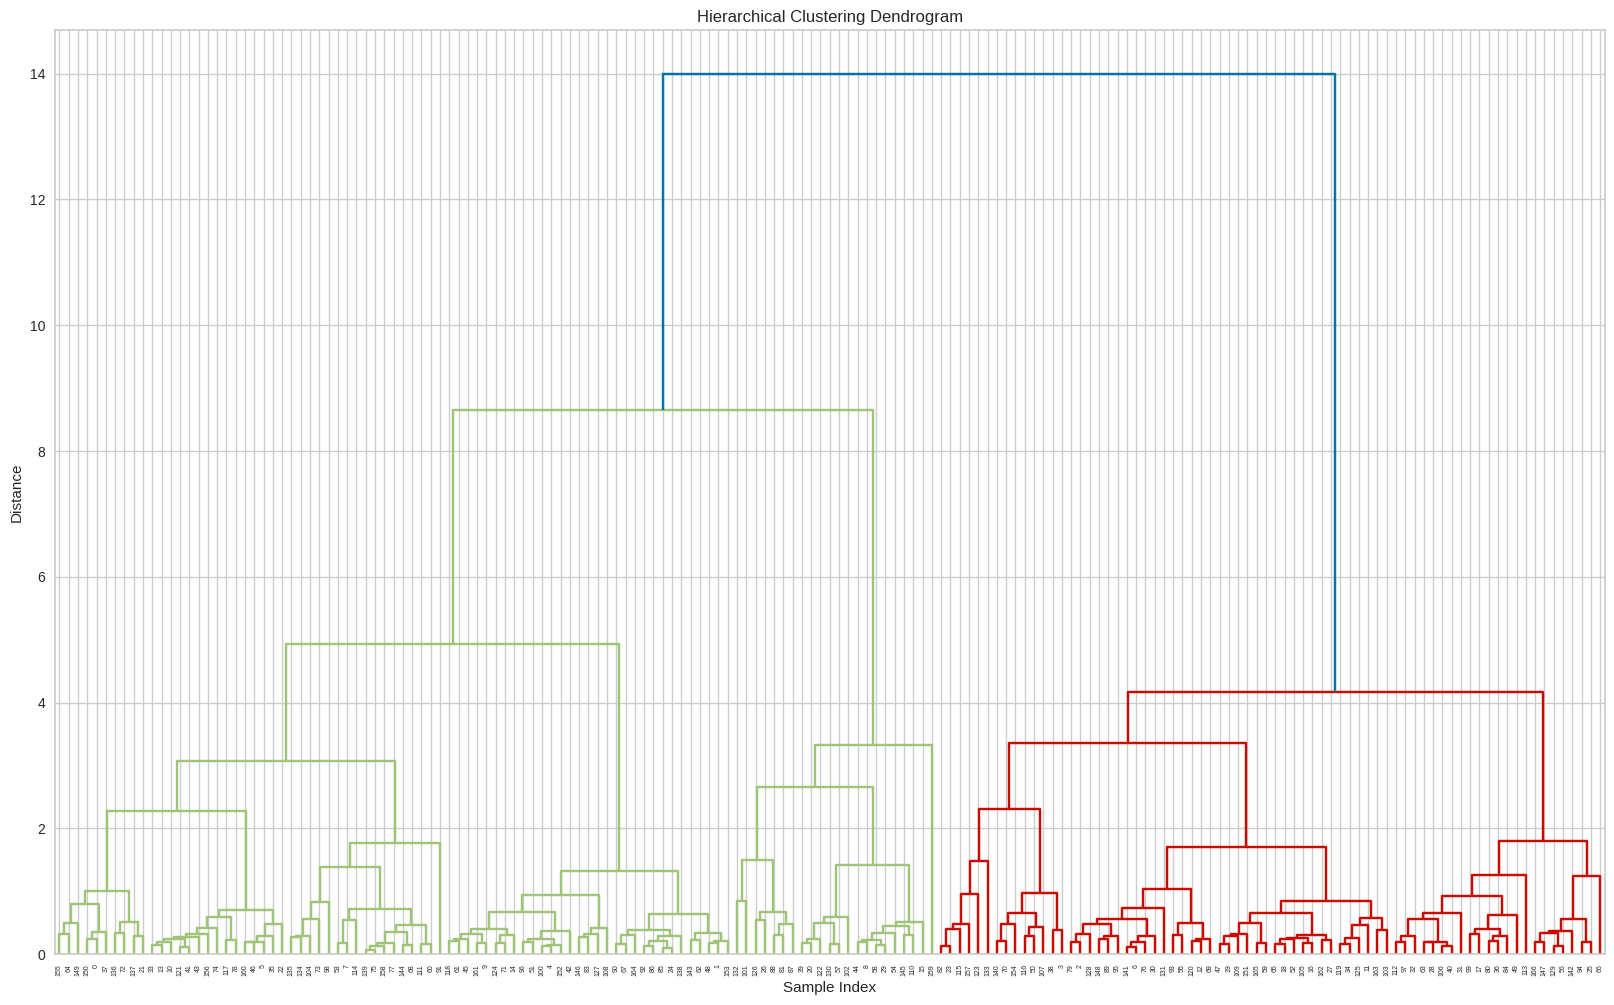

In [35]:
linked = linkage(data_scaled, method='ward') 
plt.figure(figsize=(20,12))
dendrogram(linked,
           orientation='top',distance_sort='descending',show_leaf_counts=True)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.show()


In [36]:
HAC = AgglomerativeClustering(n_clusters=3, linkage='ward')
HAC.fit(data_scaled)

AgglomerativeClustering(n_clusters=3)

In [37]:
HAC_labels = HAC.labels_
data_copy["HAC_labels"] = HAC_labels

In [38]:
HAC_labels

array([0, 0, 1, 1, 0, 0, 1, 0, 2, 0, 0, 1, 1, 0, 0, 2, 1, 1, 1, 1, 2, 0,
       0, 1, 0, 1, 2, 1, 1, 2, 1, 1, 1, 0, 1, 0, 1, 0, 1, 2, 1, 0, 0, 0,
       2, 0, 0, 1, 0, 1, 1, 0, 1, 0, 2, 1, 1, 2, 2, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 2, 1, 0, 1, 0, 0, 2,
       2, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 2, 2, 1, 0, 1, 1, 1, 0, 1,
       2, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 2, 1, 0, 1, 2, 0, 1, 1, 2, 1,
       2, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 2, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 2, 0, 0, 1, 1, 0, 1, 1])

# DBSCAN

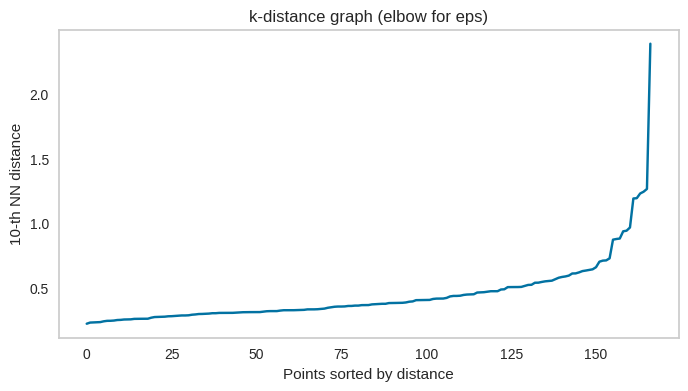

In [39]:
from sklearn.neighbors import NearestNeighbors


k = 9 #  this is for 10 samples
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(data_scaled)
distances, indices = neighbors_fit.kneighbors(data_scaled)
k_distances = np.sort(distances[:, k-1])
plt.figure(figsize=(8, 4))
plt.plot(k_distances)
plt.title("k-distance graph (elbow for eps)")
plt.xlabel("Points sorted by distance")
plt.ylabel(f"{k+1}-th NN distance")
plt.grid()
plt.show()

the opproximate value for exp is 0.4

In [40]:
DS = DBSCAN(eps = 0.44 , min_samples=10)
DS.fit(data_scaled)

DBSCAN(eps=0.44, min_samples=10)

In [41]:
DBSCAN_labels = DS.labels_
data_copy["DBSCAN_labels"] = DBSCAN_labels

In [42]:
pd.value_counts(DBSCAN_labels)

 0    111
-1     30
 1     26
Name: count, dtype: int64

it does not work well with this dataset because the overwehelming mojority was predicted in the same cluster 

# Mean Shift

In [43]:

bandwidth = estimate_bandwidth(data_scaled, quantile=0.4)

In [44]:

mean_sh = MeanShift(bandwidth=bandwidth, bin_seeding=True)
mean_sh.fit(data_scaled)

MeanShift(bandwidth=1.0505174739453222, bin_seeding=True)

In [45]:
MeanShift_labels = mean_sh.labels_
data_copy["MeanShift_labels"] = MeanShift_labels

In [46]:
MeanShift_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

In [47]:
pd.value_counts(MeanShift_labels)

0    162
1      5
Name: count, dtype: int64

# Conclusion without PCA


i am going to compare many aspects that is necessary to focus on it in order to identify whether the country needs help or not 

K-means

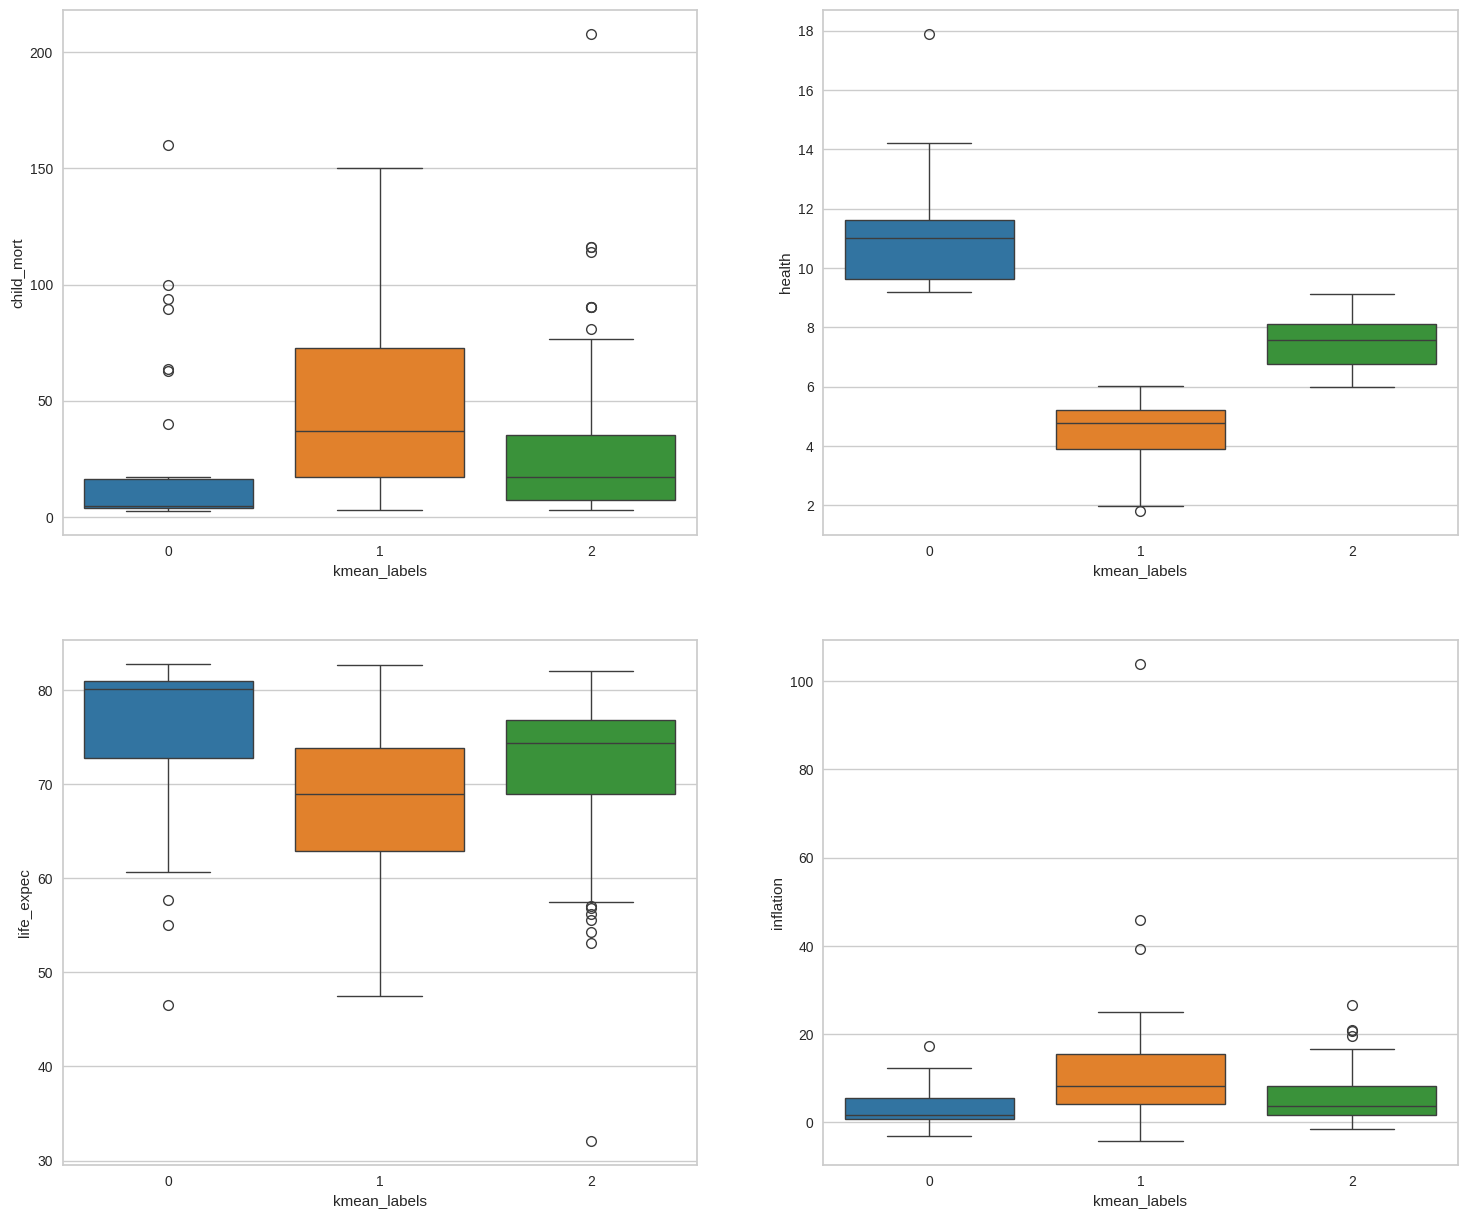

In [49]:
compared_features = ["child_mort", "health", "life_expec", "inflation"]
num_clusters = data_copy['kmean_labels'].nunique()
palette = sns.color_palette("tab10", num_clusters) 
fig , axes = plt.subplots(2,2,figsize= (18,15))
axes = axes.flatten()
for idx , column in enumerate(compared_features):
    ax = axes[idx]

    sns.boxplot(data=data_copy, x='kmean_labels', y=column, ax=ax, palette=palette)


Cluster 0

child_mort: Very low (best among the clusters)

health: High (best)

life_expect: Very high

inflation: Low

Interpretation: This group is doing very well — low child mortality, high life expectancy, strong healthcare, and low inflation.

They do not need help.

Cluster 1

child_mort: Highest among all clusters

health: Negative (likely poor health infrastructure or funding)

life_expect: Moderate, with a wide range

inflation: Highest among all

Interpretation: This cluster is struggling the most — high child mortality, poor healthcare, lower and more variable life expectancy, and high inflation.

They definitely need help — both in healthcare and economic development.

Cluster 2

child_mort: Moderate, better than cluster 1 but worse than cluster 0

health: Moderate to low

life_expect: High (but with some variability)

inflation: Low to moderate

Interpretation: This group is in between — doing better than cluster 1 but not as well as cluster 0. They might need some support in healthcare, though child mortality and inflation are manageable.

They might need help, depending on the specific context or priorities.

In [50]:
# getting the names of the countries for each cluster

cluster_zero = data_copy[data_copy["kmean_labels"]==0].country
cluster_one = data_copy[data_copy["kmean_labels"]==1].country
cluster_two = data_copy[data_copy["kmean_labels"]==2].country


In [51]:
print("country with cluster 0 that they dont need help ")
for i in cluster_zero :
    print(i)


country with cluster 0 that they dont need help 
Austria
Belgium
Bosnia and Herzegovina
Burundi
Canada
Costa Rica
Denmark
France
Georgia
Germany
Greece
Iceland
Ireland
Italy
Japan
Kiribati
Lesotho
Liberia
Micronesia, Fed. Sts.
Moldova
Netherlands
New Zealand
Norway
Portugal
Rwanda
Serbia
Sierra Leone
Slovenia
Spain
Sweden
Switzerland
United Kingdom
United States


In [ ]:
print("countries with cluster 1 ")
for i in cluster_one :
    print(i)


countries with cluster 1 that they need help
Algeria
Angola
Armenia
Azerbaijan
Bahrain
Bangladesh
Belarus
Belize
Benin
Bhutan
Bolivia
Brunei
Cambodia
Cameroon
Cape Verde
Central African Republic
Chad
China
Comoros
Congo, Rep.
Cote d'Ivoire
Egypt
Equatorial Guinea
Eritrea
Fiji
Gabon
Gambia
Ghana
Grenada
Guinea
Guyana
India
Indonesia
Iran
Jamaica
Kazakhstan
Kenya
Kuwait
Lao
Libya
Madagascar
Malaysia
Mali
Mauritania
Mongolia
Morocco
Mozambique
Myanmar
Nepal
Niger
Nigeria
Oman
Pakistan
Paraguay
Peru
Philippines
Qatar
Romania
Russia
Saudi Arabia
Senegal
Seychelles
Singapore
Sri Lanka
St. Vincent and the Grenadines
Tajikistan
Tanzania
Thailand
Tonga
Turkmenistan
United Arab Emirates
Uzbekistan
Vanuatu
Venezuela
Yemen
Zambia


In [ ]:
print("countries with cluster 1 ")
for i in cluster_two :
    print(i)

countries with cluster 1 that they might need help
Afghanistan
Albania
Antigua and Barbuda
Argentina
Australia
Bahamas
Barbados
Botswana
Brazil
Bulgaria
Burkina Faso
Chile
Colombia
Congo, Dem. Rep.
Croatia
Cyprus
Czech Republic
Dominican Republic
Ecuador
El Salvador
Estonia
Finland
Guatemala
Guinea-Bissau
Haiti
Hungary
Iraq
Israel
Jordan
Kyrgyz Republic
Latvia
Lebanon
Lithuania
Luxembourg
Macedonia, FYR
Malawi
Maldives
Malta
Mauritius
Montenegro
Namibia
Panama
Poland
Samoa
Slovak Republic
Solomon Islands
South Africa
South Korea
Sudan
Suriname
Timor-Leste
Togo
Tunisia
Turkey
Uganda
Ukraine
Uruguay
Vietnam


HAC

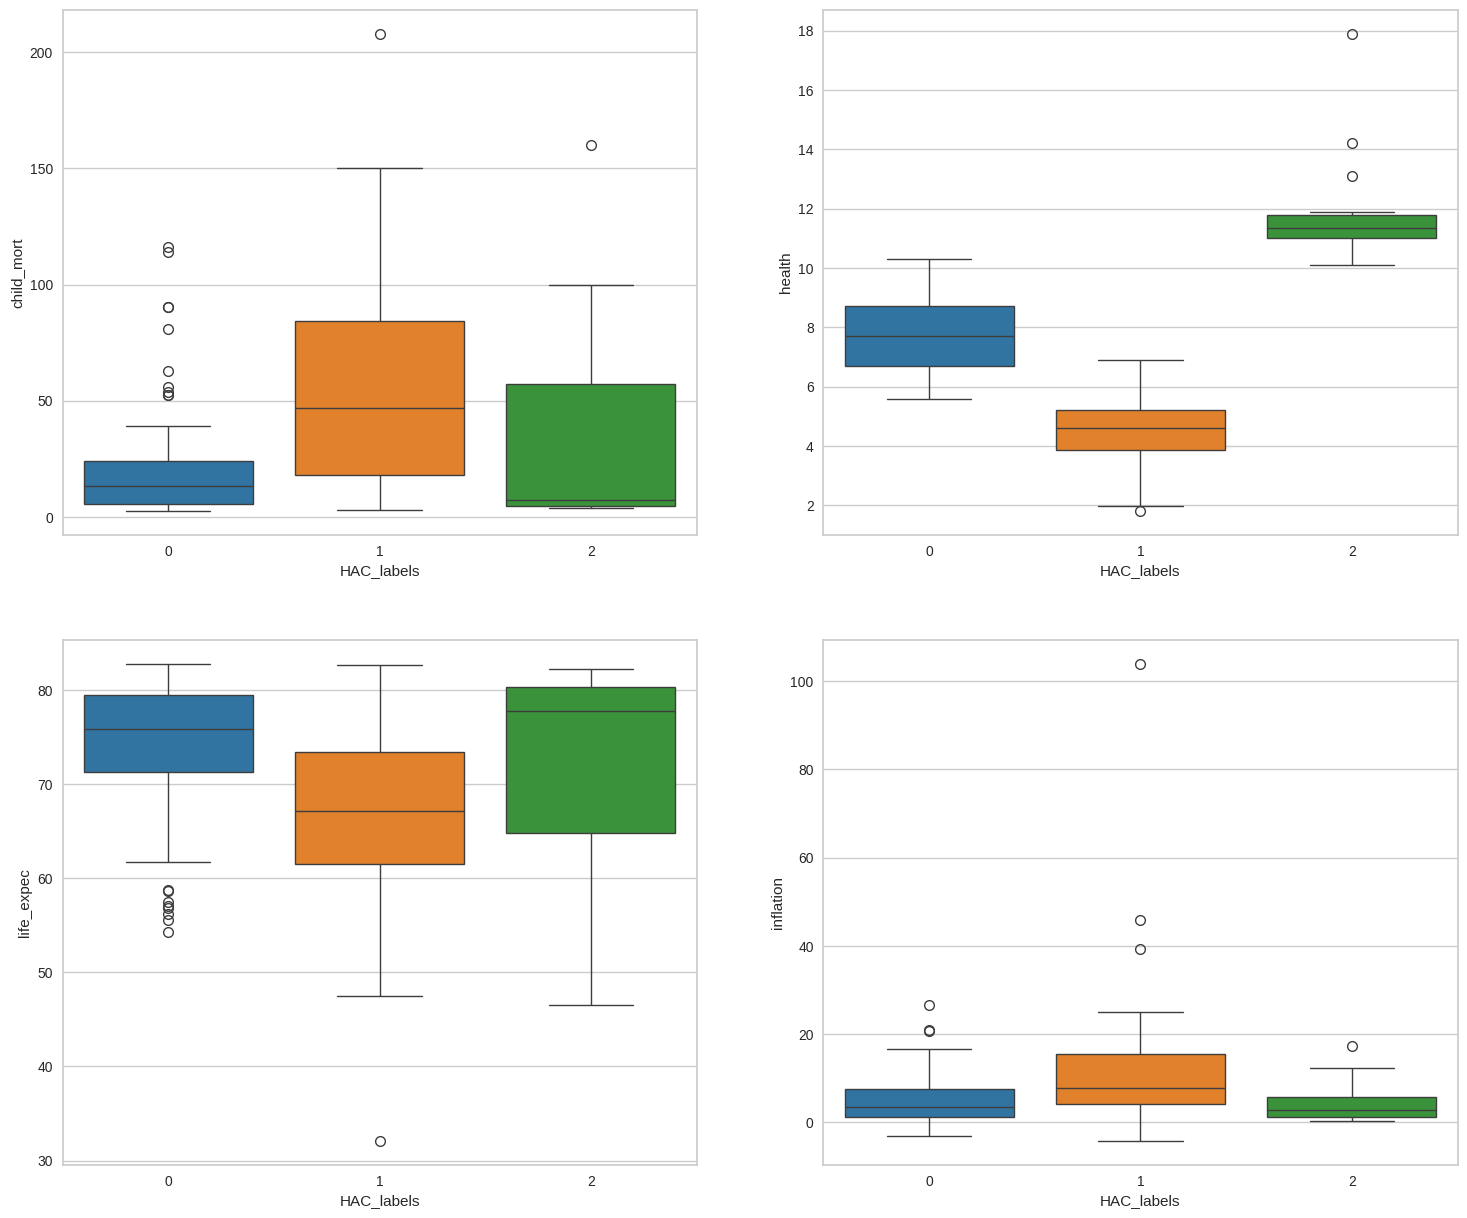

In [55]:
compared_features = ["child_mort", "health", "life_expec", "inflation"]
num_clusters = data_copy['HAC_labels'].nunique()
palette = sns.color_palette("tab10", num_clusters) 
fig , axes = plt.subplots(2,2,figsize= (18,15))
axes = axes.flatten()
for idx , column in enumerate(compared_features):
    ax = axes[idx]

    sns.boxplot(data=data_copy, x='HAC_labels', y=column, ax=ax, palette=palette)


Cluster 0 (Blue)

Child Mortality: Low (most values below 40)

Health: Mid to high (6–10% of GDP)

Life Expectancy: High (70–82 years)

Inflation: Low (mostly <10%)

Interpretation: This group is doing well. Low mortality, high life expectancy, good healthcare spending, and low inflation.

No help needed — developed countries likely.



Cluster 1 (Orange)

Child Mortality: Highest (up to 200 per 1,000)

Health: Lowest (2–7%)

Life Expectancy: Lowest (some below 50 years)

Inflation: Variable, with many above 10% (even 100+ in outliers)

Interpretation: This cluster is struggling significantly. High mortality, poor healthcare, low life expectancy, and unstable economies.

Definitely needs help — likely least developed or under-resourced countries.

Cluster 2 (Green)

Child Mortality: Mid (typically 5–60)

Health: Highest (10–12% or more)

Life Expectancy: High (around 75–82)

Inflation: Low and stable (close to 0–10%)

Interpretation: Doing very well in most areas — good healthcare, low inflation, high life expectancy — but slightly higher child mortality than Cluster 0.

Mild help maybe — emerging economies or countries with good systems but some inequality.

In [56]:
cluster_zero = data_copy[data_copy["HAC_labels"]==0].country
cluster_one = data_copy[data_copy["HAC_labels"]==1].country
cluster_two = data_copy[data_copy["HAC_labels"]==2].country


In [ ]:
print("country with cluster 0 ")
for i in cluster_zero :
    print(i)


country with cluster 0 that they dont need help 
Afghanistan
Albania
Antigua and Barbuda
Argentina
Australia
Azerbaijan
Bahamas
Barbados
Belarus
Botswana
Brazil
Bulgaria
Chile
Colombia
Congo, Dem. Rep.
Croatia
Cyprus
Czech Republic
Dominican Republic
Ecuador
El Salvador
Estonia
Finland
Greece
Grenada
Guatemala
Guinea-Bissau
Hungary
Iceland
Iran
Iraq
Ireland
Israel
Italy
Japan
Jordan
Kyrgyz Republic
Latvia
Lebanon
Lithuania
Luxembourg
Macedonia, FYR
Maldives
Malta
Mauritius
Montenegro
Namibia
New Zealand
Norway
Panama
Paraguay
Poland
Romania
Samoa
Slovak Republic
Slovenia
Solomon Islands
South Africa
South Korea
Spain
Suriname
Sweden
Tajikistan
Timor-Leste
Togo
Tunisia
Turkey
Uganda
Ukraine
United Kingdom
Uruguay
Uzbekistan
Vietnam


In [ ]:
print("countries with cluster 1 ")
for i in cluster_one :
    print(i)


countries with cluster 1 that they need help
Algeria
Angola
Armenia
Bahrain
Bangladesh
Belize
Benin
Bhutan
Bolivia
Brunei
Burkina Faso
Cambodia
Cameroon
Cape Verde
Central African Republic
Chad
China
Comoros
Congo, Rep.
Cote d'Ivoire
Egypt
Equatorial Guinea
Eritrea
Fiji
Gabon
Gambia
Ghana
Guinea
Guyana
Haiti
India
Indonesia
Jamaica
Kazakhstan
Kenya
Kuwait
Lao
Libya
Madagascar
Malawi
Malaysia
Mali
Mauritania
Mongolia
Morocco
Mozambique
Myanmar
Nepal
Niger
Nigeria
Oman
Pakistan
Peru
Philippines
Qatar
Russia
Saudi Arabia
Senegal
Seychelles
Singapore
Sri Lanka
St. Vincent and the Grenadines
Sudan
Tanzania
Thailand
Tonga
Turkmenistan
United Arab Emirates
Vanuatu
Venezuela
Yemen
Zambia


In [ ]:
print("countries with cluster 1 ")
for i in cluster_two :
    print(i)

countries with cluster 1 that they might need help
Austria
Belgium
Bosnia and Herzegovina
Burundi
Canada
Costa Rica
Denmark
France
Georgia
Germany
Kiribati
Lesotho
Liberia
Micronesia, Fed. Sts.
Moldova
Netherlands
Portugal
Rwanda
Serbia
Sierra Leone
Switzerland
United States


DBSCAN

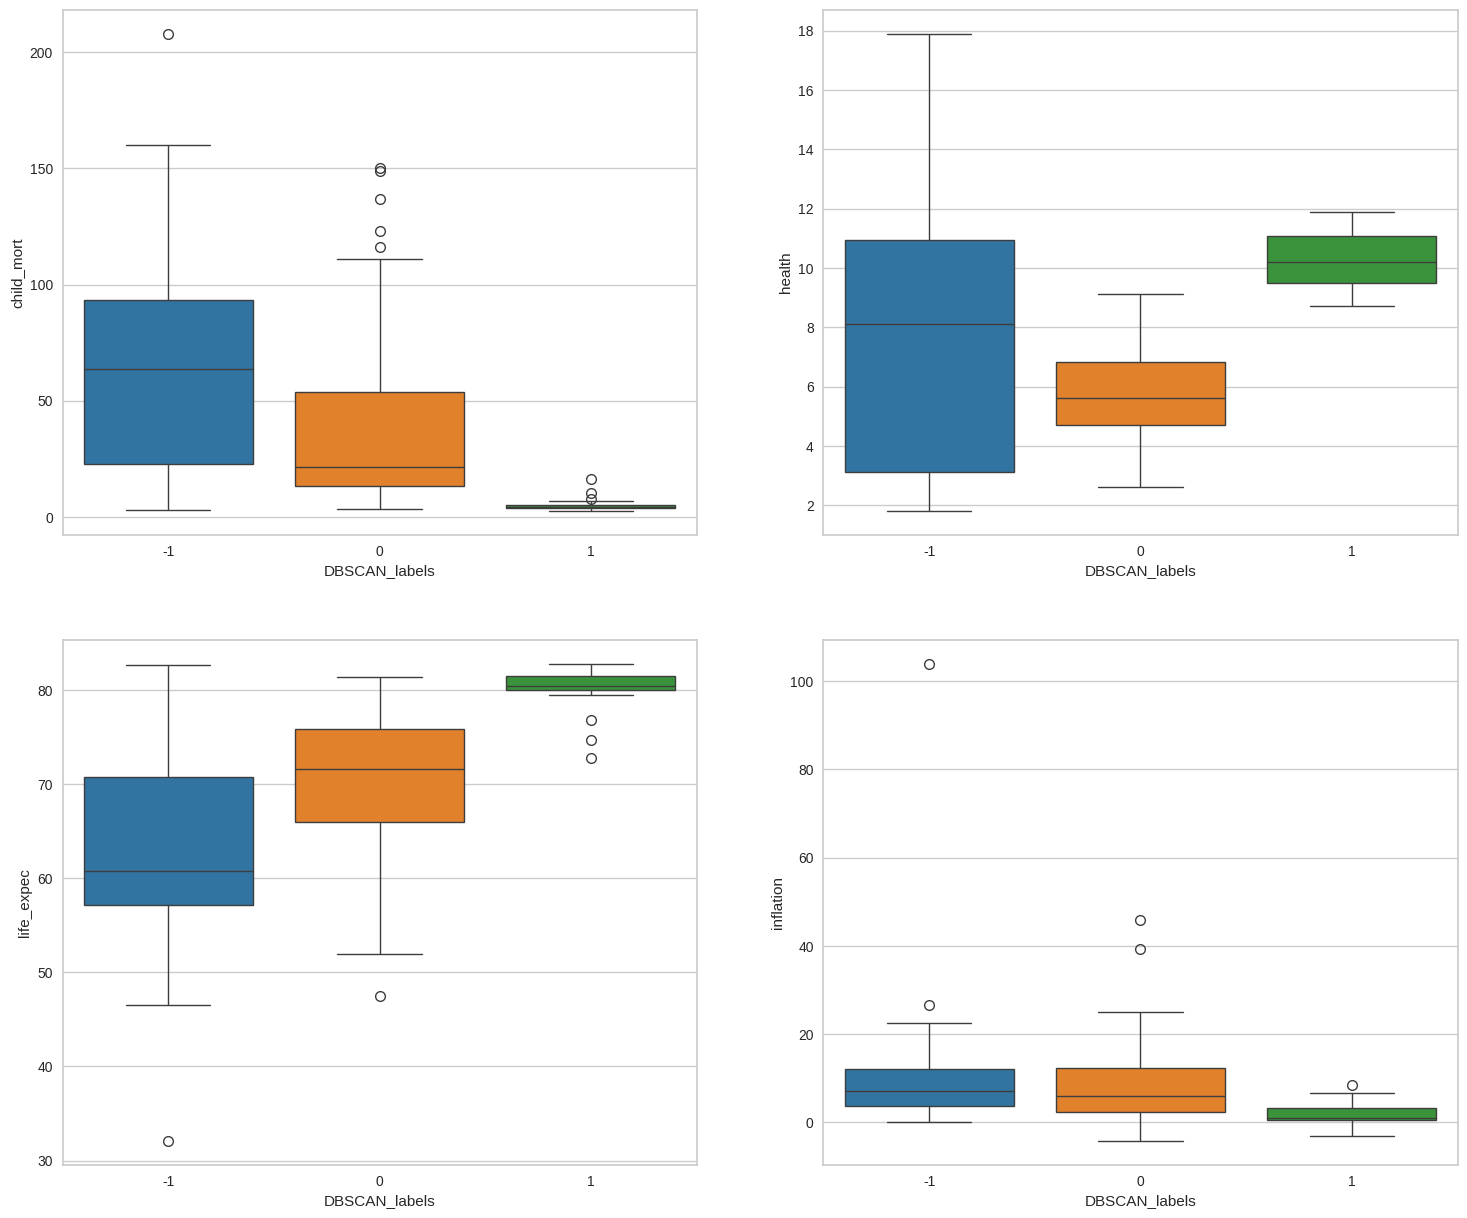

In [60]:
compared_features = ["child_mort", "health", "life_expec", "inflation"]
num_clusters = data_copy['DBSCAN_labels'].nunique()
palette = sns.color_palette("tab10", num_clusters) 
fig , axes = plt.subplots(2,2,figsize= (18,15))
axes = axes.flatten()
for idx , column in enumerate(compared_features):
    ax = axes[idx]

    sns.boxplot(data=data_copy, x='DBSCAN_labels', y=column, ax=ax, palette=palette)

 cluster -1 → Outliers (Blue Cluster)
 
Child Mortality: Very high, widely spread (up to 200)

Health: Widely spread, some very low (~2) to high (~18)

Life Expectancy: Highly variable, even as low as ~30

Inflation: Most variable — ranges up to 100+

These outliers need serious help, and further analysis to separate them 

cluster 0 (Orange Cluster)

Child Mortality: Moderate (centered around 40)

Health: Moderate (~4–9%)

Life Expectancy: Decent (around 65–77)

Inflation: Moderate (<30%)

Interpretation: These are middle-tier countries, doing okay but with room for improvement.

Somewhat decent health and life expectancy

Inflation and child mortality still a concern

Might need help in economic stability and child health

cluster 1 (Green Cluster)

Child Mortality: Very low (under 10)

Health: Highest (9–12%)

Life Expectancy: Highest (75–85 years)

Inflation: Very low (near 0–5%)

Interpretation: These are high-performing countries:

Excellent healthcare investment

Long life expectancy

Economic stability

Do not need help



In [61]:
cluster_zero = data_copy[data_copy["DBSCAN_labels"]==-1].country
cluster_one = data_copy[data_copy["DBSCAN_labels"]==0].country
cluster_two = data_copy[data_copy["DBSCAN_labels"]==1].country


In [62]:
print("country with cluster -1 that need help and special analyse")
for i in cluster_zero :
    print(i)


country with cluster -1 that need help and special analyse
Afghanistan
Angola
Botswana
Brunei
Burundi
Congo, Dem. Rep.
Congo, Rep.
Guinea-Bissau
Haiti
Kiribati
Kuwait
Lesotho
Liberia
Luxembourg
Malta
Micronesia, Fed. Sts.
Moldova
Myanmar
Nigeria
Pakistan
Qatar
Rwanda
Sierra Leone
Singapore
South Africa
Timor-Leste
Togo
Turkmenistan
Uganda
United States


In [ ]:
print("countries with cluster 0")
for i in cluster_one :
    print(i)


countries with cluster 1 that they might need help
Albania
Algeria
Antigua and Barbuda
Argentina
Armenia
Azerbaijan
Bahamas
Bahrain
Bangladesh
Barbados
Belarus
Belize
Benin
Bhutan
Bolivia
Brazil
Bulgaria
Burkina Faso
Cambodia
Cameroon
Cape Verde
Central African Republic
Chad
Chile
China
Colombia
Comoros
Cote d'Ivoire
Croatia
Cyprus
Czech Republic
Dominican Republic
Ecuador
Egypt
El Salvador
Equatorial Guinea
Eritrea
Estonia
Fiji
Gabon
Gambia
Ghana
Grenada
Guatemala
Guinea
Guyana
Hungary
India
Indonesia
Iran
Iraq
Israel
Jamaica
Jordan
Kazakhstan
Kenya
Kyrgyz Republic
Lao
Latvia
Lebanon
Libya
Lithuania
Macedonia, FYR
Madagascar
Malawi
Malaysia
Maldives
Mali
Mauritania
Mauritius
Mongolia
Montenegro
Morocco
Mozambique
Namibia
Nepal
Niger
Oman
Panama
Paraguay
Peru
Philippines
Poland
Romania
Russia
Samoa
Saudi Arabia
Senegal
Seychelles
Slovak Republic
Solomon Islands
South Korea
Sri Lanka
St. Vincent and the Grenadines
Sudan
Suriname
Tajikistan
Tanzania
Thailand
Tonga
Tunisia
Turkey
Ukraine


In [ ]:
print("countries with cluster 1 ")
for i in cluster_two :
    print(i)

countries with cluster 1 that do not need help
Australia
Austria
Belgium
Bosnia and Herzegovina
Canada
Costa Rica
Denmark
Finland
France
Georgia
Germany
Greece
Iceland
Ireland
Italy
Japan
Netherlands
New Zealand
Norway
Portugal
Serbia
Slovenia
Spain
Sweden
Switzerland
United Kingdom


mean shift

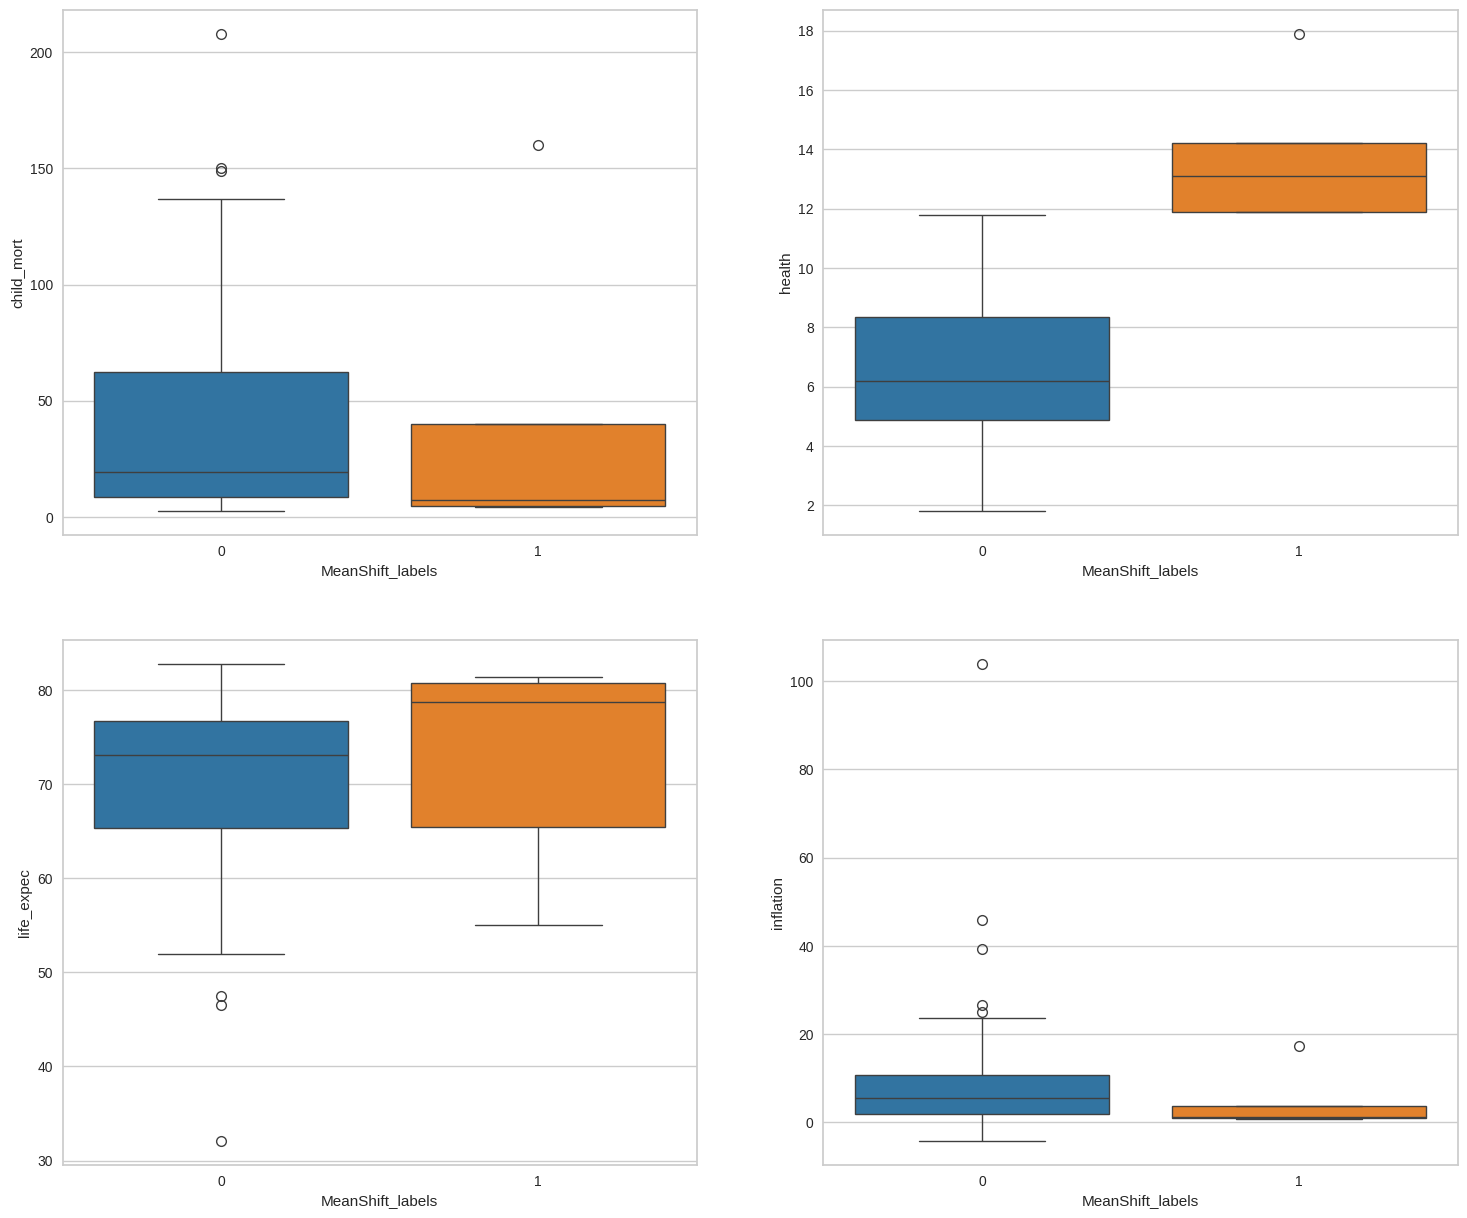

In [65]:
compared_features = ["child_mort", "health", "life_expec", "inflation"]
num_clusters = data_copy['MeanShift_labels'].nunique()
palette = sns.color_palette("tab10", num_clusters) 
fig , axes = plt.subplots(2,2,figsize= (18,15))
axes = axes.flatten()
for idx , column in enumerate(compared_features):
    ax = axes[idx]

    sns.boxplot(data=data_copy, x='MeanShift_labels', y=column, ax=ax, palette=palette)

Cluster 0 (Blue)

Child Mortality: Ranges widely (up to ~150), median around 40–50

Health: Low to moderate (4–12%)

Life Expectancy: Good (~65–80 years)

Inflation: Moderate, but with several outliers (up to 100%)

Interpretation:

Decent life expectancy, but could improve healthcare and reduce child mortality.

Economically mixed — some high inflation.

Could be a diverse group: emerging economies + some middle-income countries.

May need help, especially in healthcare access and economic stability.

Cluster 1 (Orange)

Child Mortality: Very low (almost all < 20)

Health: Very high and consistent (12–15%)

Life Expectancy: Very high (~78–83 years)

Inflation: Very low and stable (~0–5%)

Interpretation:

Strong across all indicators — best healthcare, high life expectancy, low inflation.

Likely developed, stable nations with effective systems.

No help needed



# Apply Clustering With PCA

# K-means

In [150]:
data_copy2 = pca_data.copy()

In [ ]:
def optimal_clusters(Data, knumber):
    inertia = []
    silhouette_scores = []
    for n in range(1, knumber + 1): 
        kmeans = KMeans(n_clusters=n, init='k-means++', random_state=42, n_init=10)
        kmeans.fit(Data)
        inertia.append(kmeans.inertia_)
        if(n != 1) :
            silhouette_scores.append(silhouette_score(Data, kmeans.labels_))

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    ax1 = axes[0]
    ax1.plot(range(1, knumber + 1), inertia, marker='o')
    ax1.set_title("Elbow Method")
    ax1.set_xlabel("Number of Clusters")
    ax1.set_ylabel("Inertia")

    ax2 = axes[1]
    ax2.plot(range(2, knumber + 1), silhouette_scores, marker='o', color='b', linestyle='--')
    ax2.set_title("Silhouette Scores")
    ax2.set_xlabel("Number of Clusters")
    ax2.set_ylabel("Silhouette Score")

    plt.tight_layout()
    plt.show()

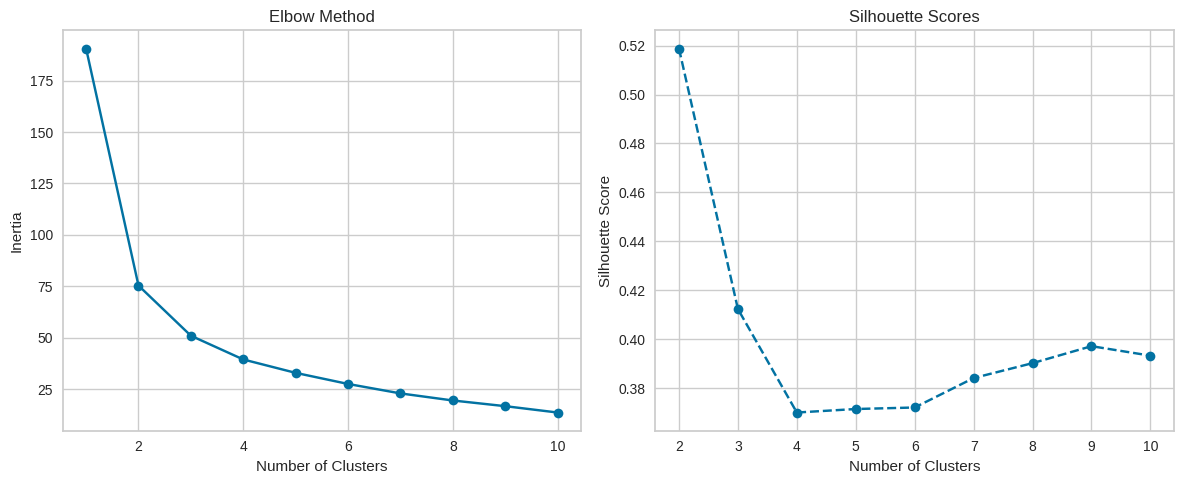

In [152]:
optimal_clusters(pca_data, 10)

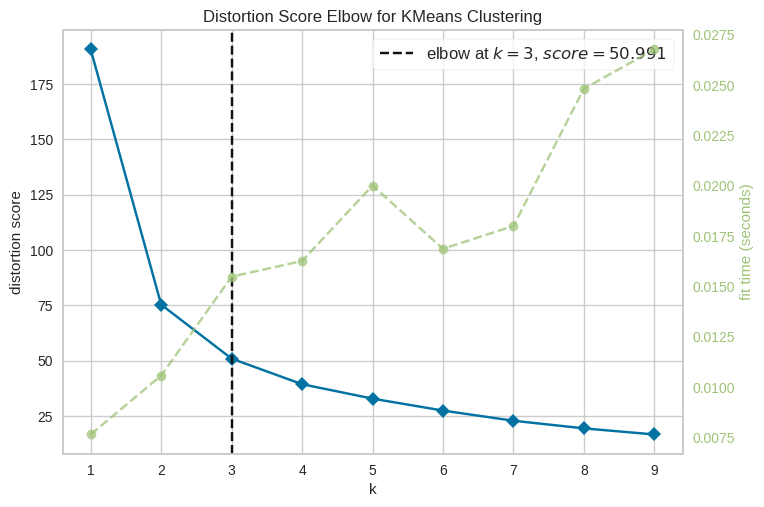

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [153]:
Kmean = KMeans(init='k-means++', n_init=10, random_state=42)
elbovis = KElbowVisualizer(Kmean ,k = (1,10))
elbovis.fit(pca_data)
elbovis.show()

In [154]:
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42, n_init=10)
kmeans.fit(pca_data)

KMeans(n_clusters=3, n_init=10, random_state=42)

In [155]:
kmean_labels = kmeans.labels_
data_copy2["kmean_labels"] = kmean_labels
data_copy["kmean_labels_PCA"] = kmean_labels

In [156]:
kmean_labels

array([0, 0, 2, 2, 0, 0, 2, 0, 1, 0, 0, 2, 2, 0, 2, 1, 2, 2, 2, 2, 1, 0,
       0, 2, 0, 0, 1, 2, 2, 1, 2, 2, 2, 0, 2, 0, 2, 0, 2, 1, 2, 0, 0, 0,
       1, 0, 0, 2, 0, 2, 2, 0, 2, 0, 1, 2, 2, 1, 1, 2, 1, 0, 0, 2, 0, 2,
       0, 0, 1, 2, 2, 2, 0, 1, 0, 1, 2, 1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 1,
       1, 2, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 1, 1, 2, 0, 2, 2, 2, 0, 2,
       1, 1, 2, 2, 1, 2, 2, 0, 0, 2, 2, 0, 1, 2, 2, 2, 1, 0, 2, 2, 1, 2,
       1, 2, 0, 1, 0, 0, 0, 1, 2, 2, 0, 0, 1, 1, 0, 2, 2, 0, 0, 2, 0, 0,
       2, 0, 0, 2, 1, 1, 0, 2, 2, 2, 0, 2, 2], dtype=int32)

In [157]:
pd.value_counts(kmean_labels)

2    72
0    62
1    33
Name: count, dtype: int64

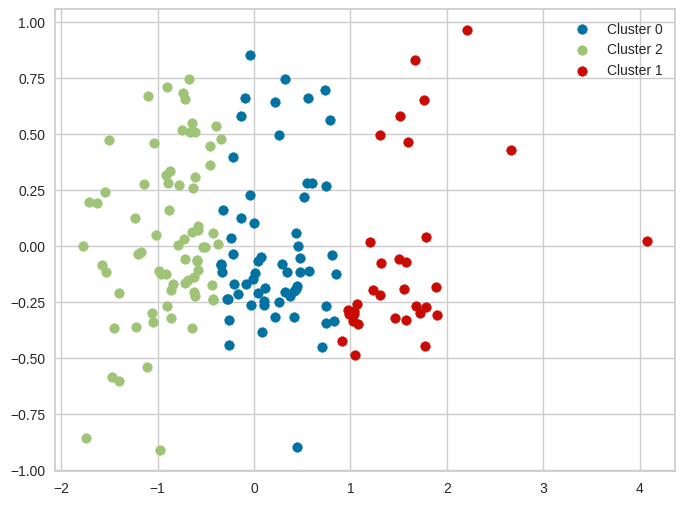

In [158]:
plt.figure(figsize=(8,6))
for cluster in data_copy2['kmean_labels'].unique():
    cluster_data = data_copy2[data_copy2['kmean_labels'] == cluster]
    plt.scatter(cluster_data['PC1'], cluster_data['PC2'], label=f'Cluster {cluster}')

plt.legend()

#  Hierarchical Agglomerative Clustering

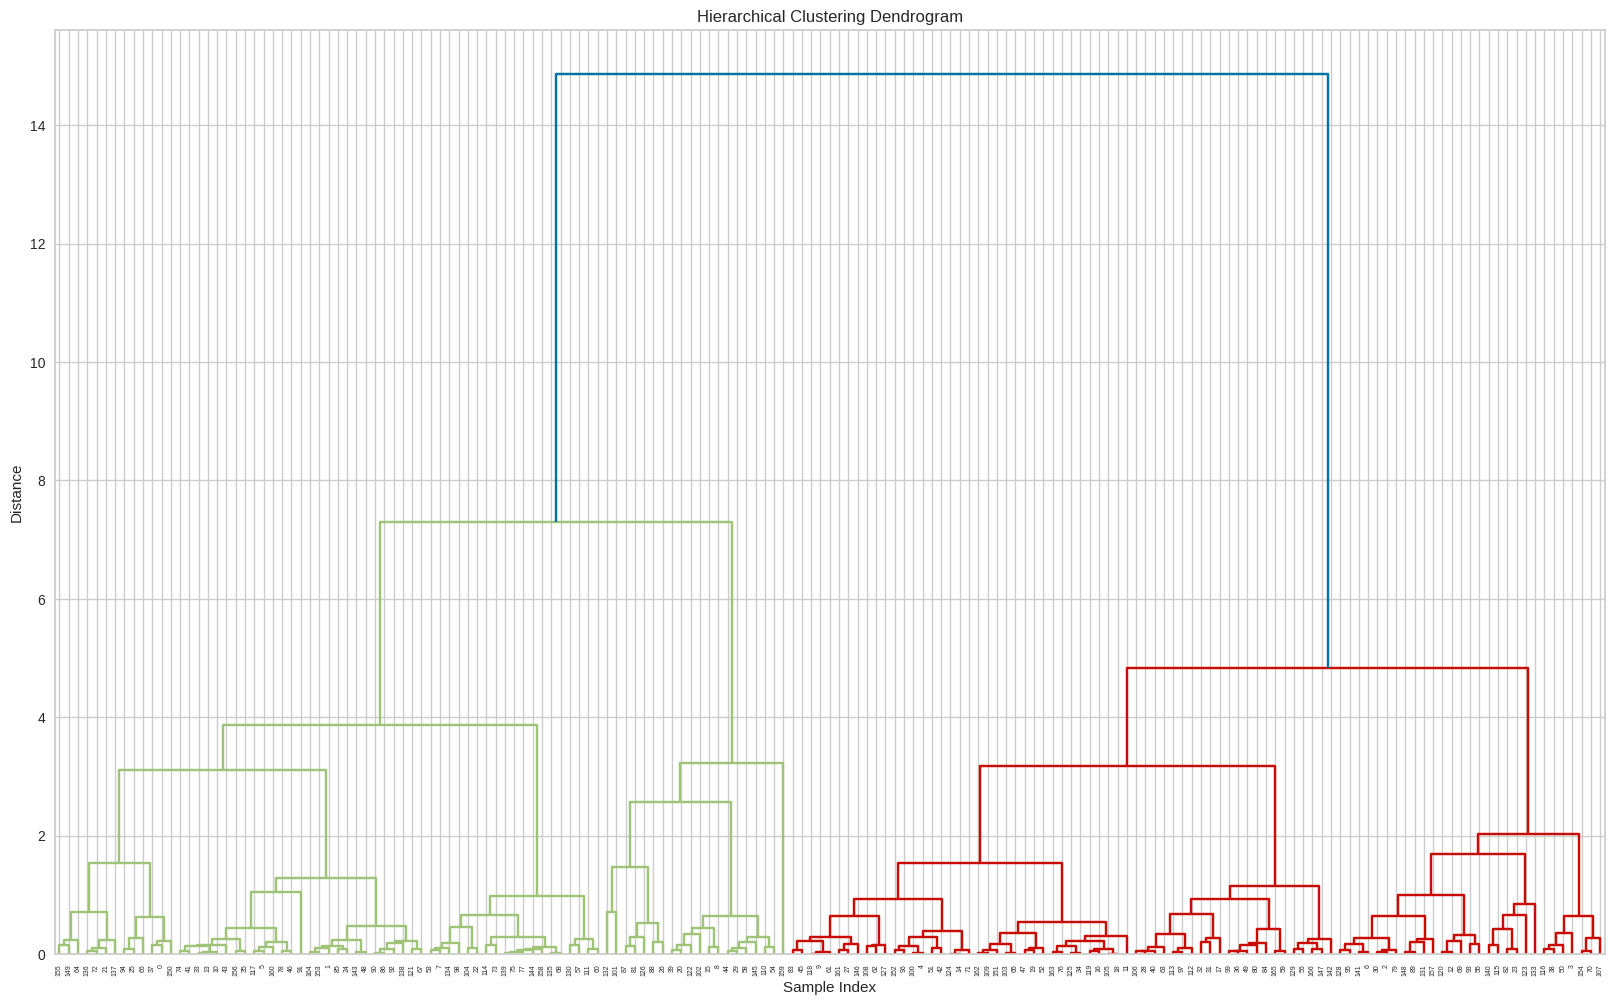

In [159]:
linked = linkage(pca_data, method='ward') 
plt.figure(figsize=(20,12))
dendrogram(linked,
           orientation='top',distance_sort='descending',show_leaf_counts=True)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.show()

In [160]:
HAC = AgglomerativeClustering(n_clusters=3, linkage='ward')
HAC.fit(pca_data)

AgglomerativeClustering(n_clusters=3)

In [161]:
HAC_labels = HAC.labels_
data_copy2["HAC_labels"] = HAC_labels
data_copy["HAC_labels_PCA"] = HAC_labels

In [162]:
HAC_labels

array([1, 1, 0, 0, 0, 1, 0, 1, 2, 0, 1, 0, 0, 1, 0, 2, 0, 0, 0, 0, 2, 1,
       1, 0, 1, 1, 2, 0, 0, 2, 0, 0, 0, 1, 0, 1, 0, 1, 0, 2, 0, 1, 0, 1,
       2, 0, 1, 0, 1, 0, 0, 0, 0, 1, 2, 0, 0, 1, 2, 0, 1, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 2, 0, 0, 0, 1, 1, 2,
       2, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 2, 2, 0, 1, 0, 0, 0, 0, 0,
       2, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 2, 0, 0, 0, 2, 0, 0, 0, 1, 0,
       2, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 2, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 1, 0, 1, 2, 1, 0, 0, 0, 1, 0, 0])

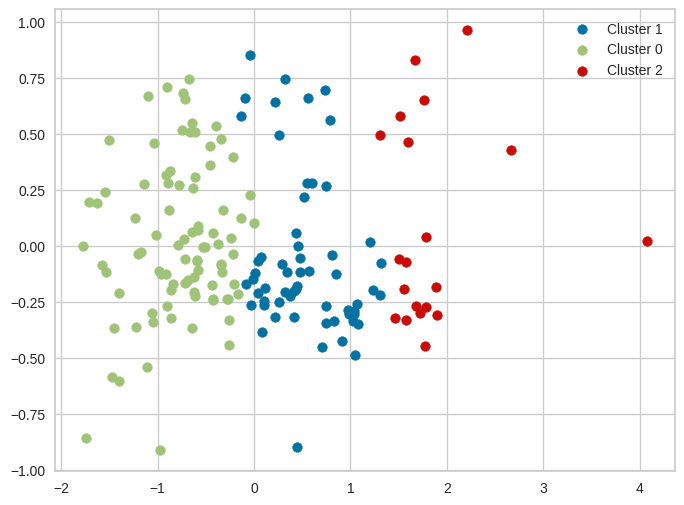

In [163]:
plt.figure(figsize=(8,6))
for cluster in data_copy2['HAC_labels'].unique():
    cluster_data = data_copy2[data_copy2['HAC_labels'] == cluster]
    plt.scatter(cluster_data['PC1'], cluster_data['PC2'], label=f'Cluster {cluster}')

plt.legend()

# DBSCAN

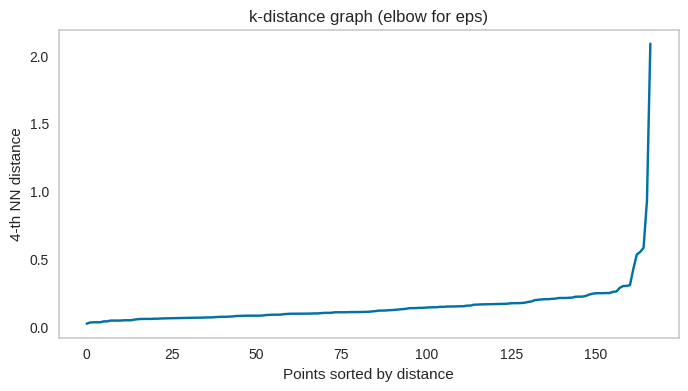

In [164]:
from sklearn.neighbors import NearestNeighbors


k = 3 #  this is for 4 samples
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(pca_data)
distances, indices = neighbors_fit.kneighbors(pca_data)
k_distances = np.sort(distances[:, k-1])
plt.figure(figsize=(8, 4))
plt.plot(k_distances)
plt.title("k-distance graph (elbow for eps)")
plt.xlabel("Points sorted by distance")
plt.ylabel(f"{k+1}-th NN distance")
plt.grid()
plt.show()

In [165]:
DS = DBSCAN(eps = 0.2 , min_samples=4)
DS.fit(pca_data)
# 0.2 , 4

DBSCAN(eps=0.2, min_samples=4)

In [ ]:
DBSCAN_labels = DS.labels_
data_copy2["DBSCAN_labels"] = DBSCAN_labels
data_copy["DBSCAN_labels_PCA"] = DBSCAN_labels

In [167]:
pd.value_counts(DBSCAN_labels)

 0    104
-1     34
 1     29
Name: count, dtype: int64

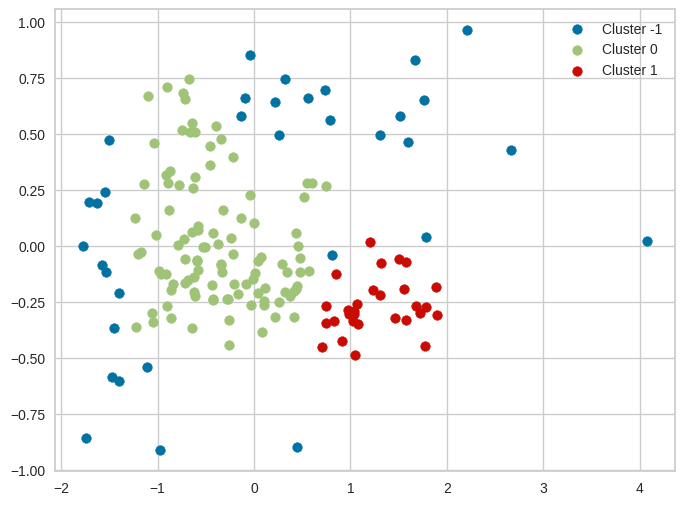

In [168]:
plt.figure(figsize=(8,6))
for cluster in data_copy2['DBSCAN_labels'].unique():
    cluster_data = data_copy2[data_copy2['DBSCAN_labels'] == cluster]
    plt.scatter(cluster_data['PC1'], cluster_data['PC2'], label=f'Cluster {cluster}')

plt.legend()

# Mean Shift

In [169]:
bandwidth = estimate_bandwidth(pca_data, quantile=0.2)

In [170]:
mean_sh = MeanShift(bandwidth=bandwidth, bin_seeding=True)
mean_sh.fit(pca_data)

MeanShift(bandwidth=0.6279777954242005, bin_seeding=True)

In [171]:
MeanShift_labels = mean_sh.labels_
data_copy2["MeanShift_labels"] = MeanShift_labels
data_copy["MeanShift_labels_PCA"] = MeanShift_labels


In [172]:
MeanShift_labels

array([1, 0, 0, 0, 0, 1, 0, 1, 2, 0, 1, 0, 0, 1, 0, 2, 0, 0, 0, 0, 2, 1,
       1, 0, 1, 0, 3, 0, 0, 2, 0, 0, 0, 1, 0, 1, 0, 1, 0, 2, 0, 1, 0, 1,
       2, 0, 1, 0, 1, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 2, 0, 0, 0, 1, 0,
       0, 1, 2, 0, 0, 0, 1, 2, 1, 2, 0, 2, 1, 0, 0, 3, 0, 0, 0, 1, 1, 3,
       3, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 4, 3, 0, 2, 0, 0, 0, 0, 0,
       2, 2, 0, 0, 2, 0, 0, 1, 0, 0, 0, 1, 2, 0, 0, 0, 3, 0, 0, 0, 2, 0,
       4, 0, 1, 2, 1, 1, 1, 2, 0, 0, 0, 1, 2, 2, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 1, 0, 2, 5, 1, 0, 0, 0, 1, 0, 0])

In [173]:
pd.value_counts(MeanShift_labels)

0    92
1    40
2    26
3     6
4     2
5     1
Name: count, dtype: int64

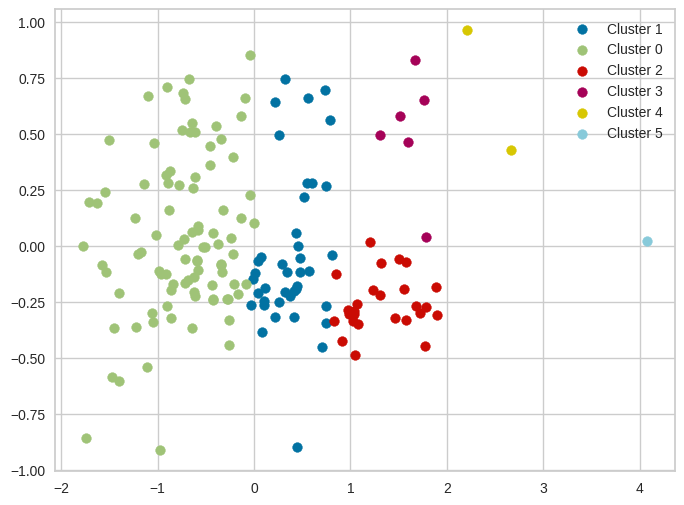

In [174]:
plt.figure(figsize=(8,6))
for cluster in data_copy2['MeanShift_labels'].unique():
    cluster_data = data_copy2[data_copy2['MeanShift_labels'] == cluster]
    plt.scatter(cluster_data['PC1'], cluster_data['PC2'], label=f'Cluster {cluster}')

plt.legend()


# Conclusion with PCA

In [175]:
data_copy

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,kmean_labels,HAC_labels,DBSCAN_labels,MeanShift_labels,kmean_labels_PCA,HAC_labels_PCA,DBSCAN_labels_PCA,MeanShift_labels_PCA
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,2,0,-1,0,0,1,-1,1
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,2,0,0,0,0,1,0,0
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,1,1,0,0,2,0,0,0
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,1,1,-1,0,2,0,-1,0
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,2,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,Vanuatu,29.2,46.6,5.25,52.7,2950,2.62,63.0,3.50,2970,1,1,0,0,2,0,0,0
163,Venezuela,17.1,28.5,4.91,17.6,16500,45.90,75.4,2.47,13500,1,1,0,0,2,0,0,0
164,Vietnam,23.3,72.0,6.84,80.2,4490,12.10,73.1,1.95,1310,2,0,0,0,0,1,0,1
165,Yemen,56.3,30.0,5.18,34.4,4480,23.60,67.5,4.67,1310,1,1,0,0,2,0,0,0


k-means

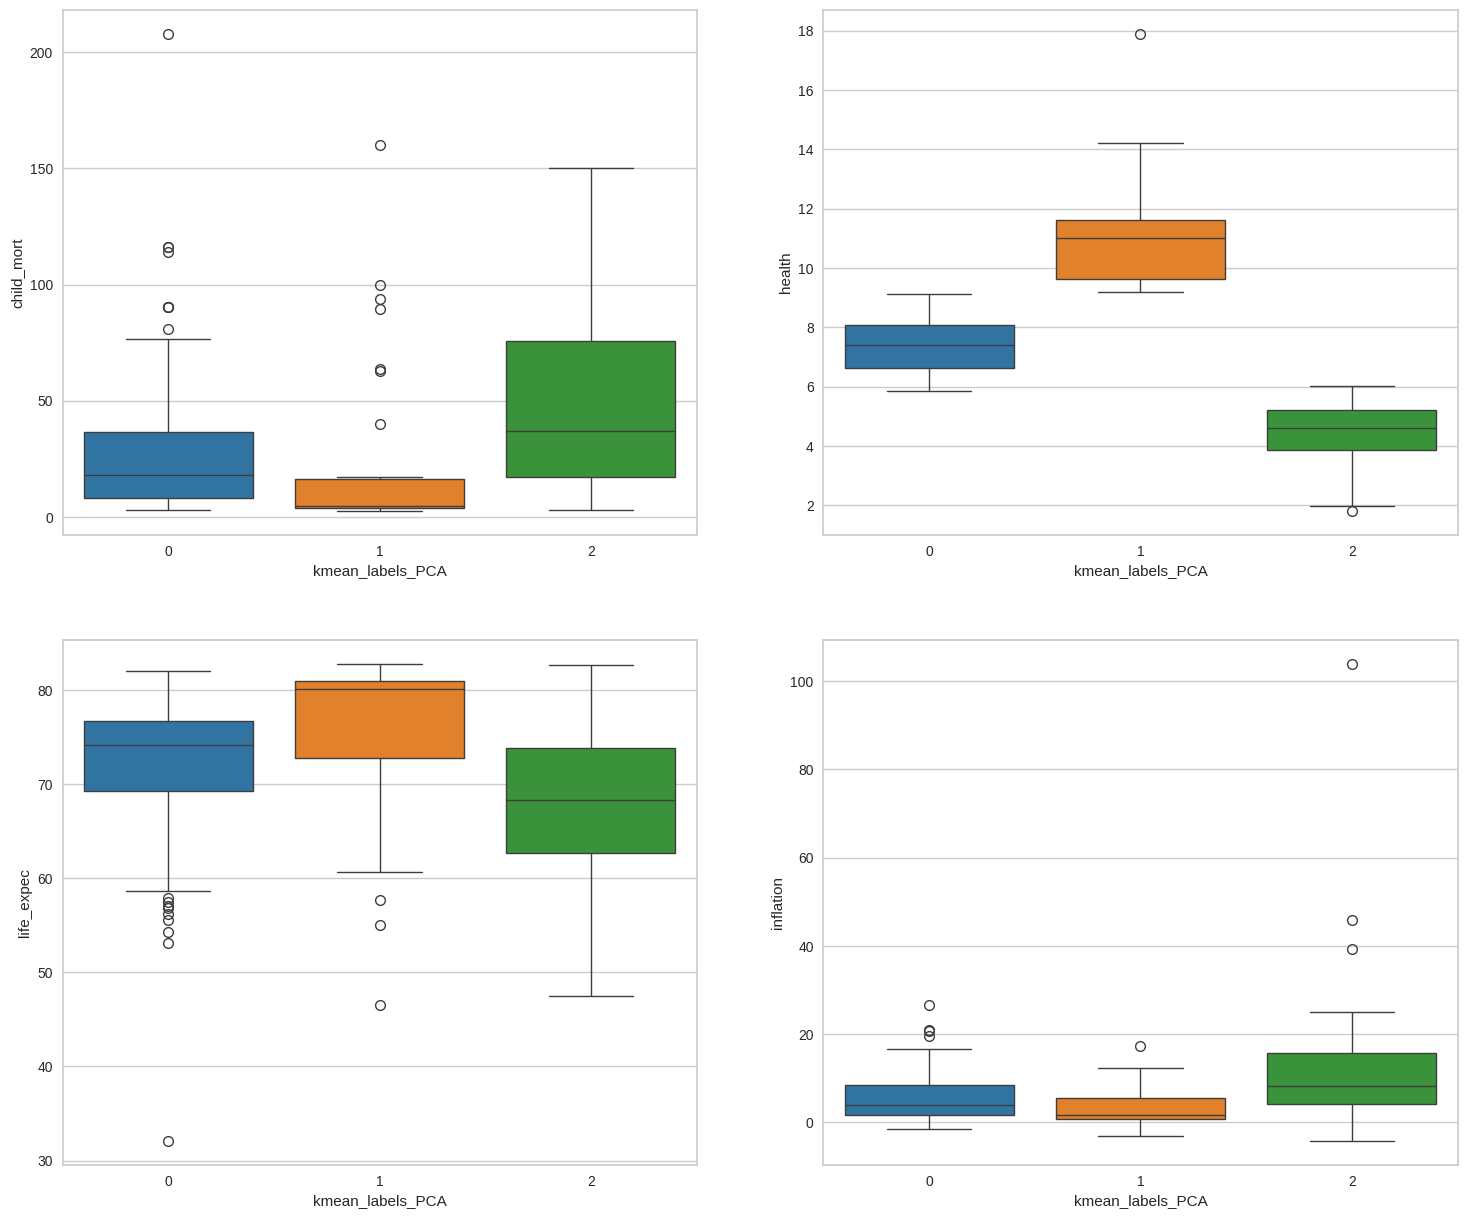

In [176]:
compared_features = ["child_mort", "health", "life_expec", "inflation"]
num_clusters = data_copy['kmean_labels_PCA'].nunique()
palette = sns.color_palette("tab10", num_clusters) 
fig , axes = plt.subplots(2,2,figsize= (18,15))
axes = axes.flatten()
for idx , column in enumerate(compared_features):
    ax = axes[idx]

    sns.boxplot(data=data_copy, x='kmean_labels_PCA', y=column, ax=ax, palette=palette)

Cluster 0 (Blue)

Child Mortality: Better than Cluster 2, worse than Cluster 1

Health Spending: Moderate

Life Expectancy: Acceptable, but below Cluster 1

Inflation: Manageable

Conclusion:
Cluster 0 includes developing or transitional countries.

May need help, depending on specific context (region, income, GDP).

Cluster 1 (Orange)

Child Mortality: Lowest

Health Spending: Highest

Life Expectancy: Highest

Inflation: Lowest and stable

Conclusion:
Cluster 1 represents developed or well-performing countries.
Does NOT need help.

Cluster 2 (Green)

Child Mortality: Highest

Health Spending: Lowest

Life Expectancy: Lowest

Inflation: Highest, with severe outliers

Conclusion:
Cluster 2 likely includes underdeveloped or at-risk nations.

Needs help (aid, healthcare, inflation control, development focus).



In [180]:
cluster_zero = data_copy[data_copy["kmean_labels_PCA"]==0].country
cluster_one = data_copy[data_copy["kmean_labels_PCA"]==1].country
cluster_two = data_copy[data_copy["kmean_labels_PCA"]==2].country


In [ ]:
print("country with cluster 0  ")
for i in cluster_zero :
    print(i)


In [ ]:
print("countries with cluster 1 ")
for i in cluster_one :
    print(i)


In [ ]:
print("countries with cluster 1 ")
for i in cluster_two :
    print(i)

HAC

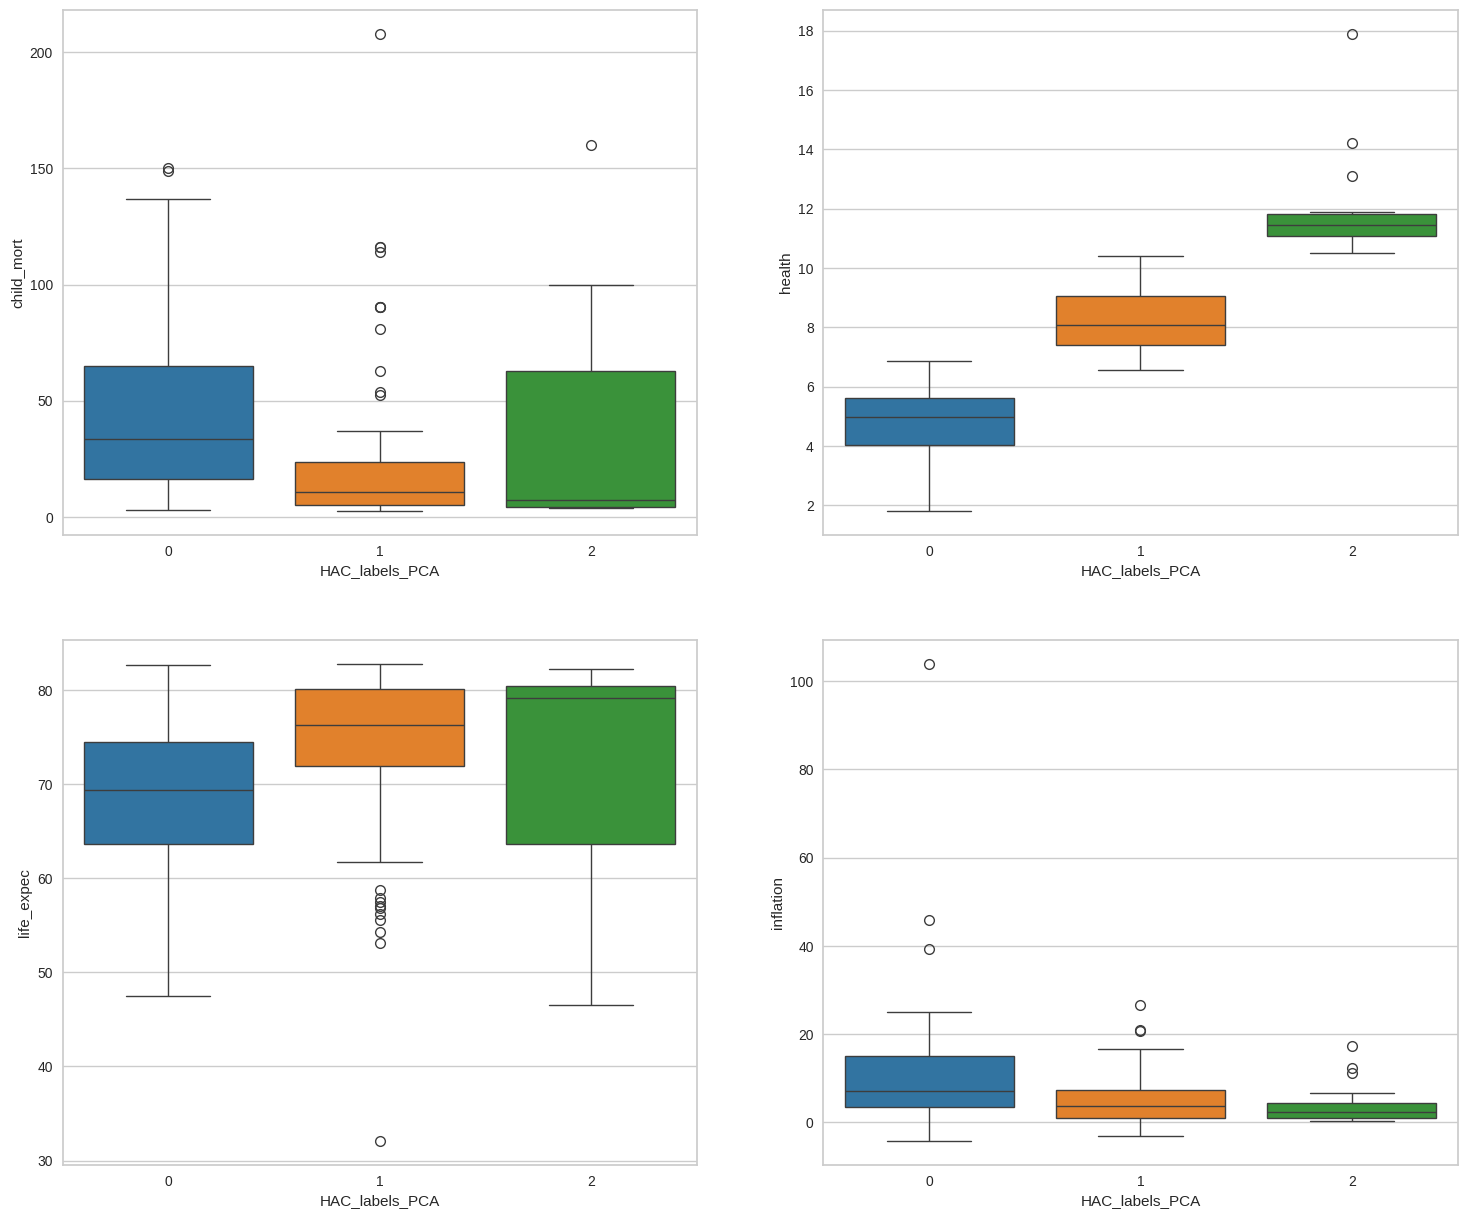

In [177]:
compared_features = ["child_mort", "health", "life_expec", "inflation"]
num_clusters = data_copy['HAC_labels_PCA'].nunique()
palette = sns.color_palette("tab10", num_clusters) 
fig , axes = plt.subplots(2,2,figsize= (18,15))
axes = axes.flatten()
for idx , column in enumerate(compared_features):
    ax = axes[idx]

    sns.boxplot(data=data_copy, x='HAC_labels_PCA', y=column, ax=ax, palette=palette)


 Cluster 0 (Blue)

Child Mortality: High, with large spread

Health Spending: Low

Life Expectancy: Lower

Inflation: High, wide range (many outliers)

Conclusion:
This cluster likely represents developing or low-income countries with weak healthcare, high child mortality, and economic instability.

Needs help

Cluster 1 (Orange)

Child Mortality: Lowest

Health Spending: Moderate to high

Life Expectancy: High (better distribution)

Inflation: Low and stable

Conclusion:
This cluster includes developed countries with strong health systems and low economic volatility.

Does not need help

Cluster 2 (Green)

Child Mortality: Low (slightly higher than Cluster 1 but much better than Cluster 0)

Health Spending: Highest

Life Expectancy: High (similar to Cluster 1)

Inflation: Lowest and most stable

Conclusion:
This cluster shows countries with strongest overall metrics — possibly even better than Cluster 1 on health and inflation.

Does not need help (top-performing nations)

In [ ]:
cluster_zero = data_copy[data_copy["HAC_labels_PCA"]==0].country
cluster_one = data_copy[data_copy["HAC_labels_PCA"]==1].country
cluster_two = data_copy[data_copy["HAC_labels_PCA"]==2].country

In [ ]:
print("country with cluster 0  ")
for i in cluster_zero :
    print(i)


In [ ]:
print("countries with cluster 1 ")
for i in cluster_one :
    print(i)


In [ ]:
print("countries with cluster 1 ")
for i in cluster_two :
    print(i)

DBSCAN

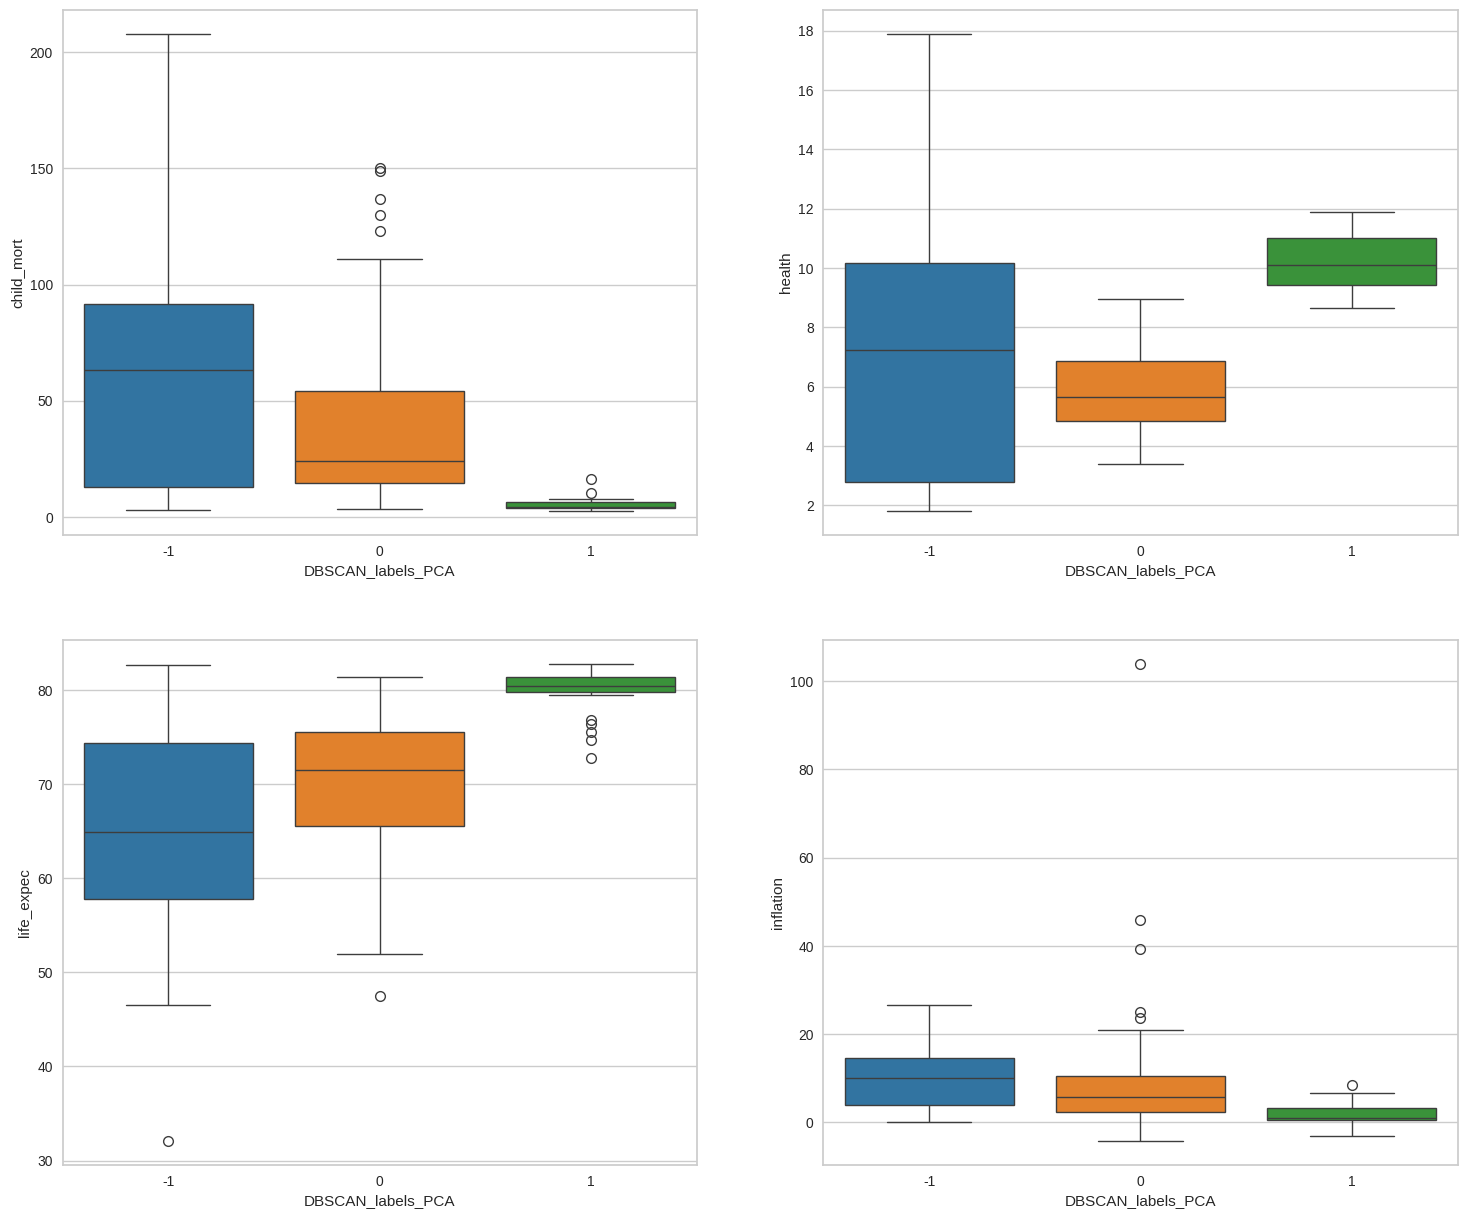

In [178]:
compared_features = ["child_mort", "health", "life_expec", "inflation"]
num_clusters = data_copy['DBSCAN_labels_PCA'].nunique()
palette = sns.color_palette("tab10", num_clusters) 
fig , axes = plt.subplots(2,2,figsize= (18,15))
axes = axes.flatten()
for idx , column in enumerate(compared_features):
    ax = axes[idx]

    sns.boxplot(data=data_copy, x='DBSCAN_labels_PCA', y=column, ax=ax, palette=palette)

cluster -1 → Outliers (Blue Cluster)
 
Child Mortality: Very high, widely spread (up to 200)

Health: Widely spread, some very low (~2) to high (~18)

Life Expectancy: Highly variable, even as low as ~30

Inflation: Most variable — ranges up to 100+

These outliers need serious help, and further analysis to separate them 

cluster 0 (Orange Cluster)

Child Mortality: Moderate (centered around 40)

Health: Moderate (~4–9%)

Life Expectancy: Decent (around 65–77)

Inflation: Moderate (<30%)

Interpretation: These are middle-tier countries, doing okay but with room for improvement.

Somewhat decent health and life expectancy

Inflation and child mortality still a concern

Might need help in economic stability and child health

cluster 1 (Green Cluster)

Child Mortality: Very low (under 10)

Health: Highest (9–12%)

Life Expectancy: Highest (75–85 years)

Inflation: Very low (near 0–5%)

Interpretation: These are high-performing countries:

Excellent healthcare investment

Long life expectancy

Economic stability

Do not need help

In [ ]:
cluster_zero = data_copy[data_copy["DBSCAN_labels_PCA"]==-1].country
cluster_one = data_copy[data_copy["DBSCAN_labels_PCA"]==0].country
cluster_two = data_copy[data_copy["DBSCAN_labels_PCA"]==1].country


In [ ]:
print("country with cluster -1 that need help and special analyse")
for i in cluster_zero :
    print(i)


In [ ]:
print("countries with cluster 0")
for i in cluster_one :
    print(i)


In [ ]:
print("countries with cluster 1 ")
for i in cluster_two :
    print(i)

mean shift

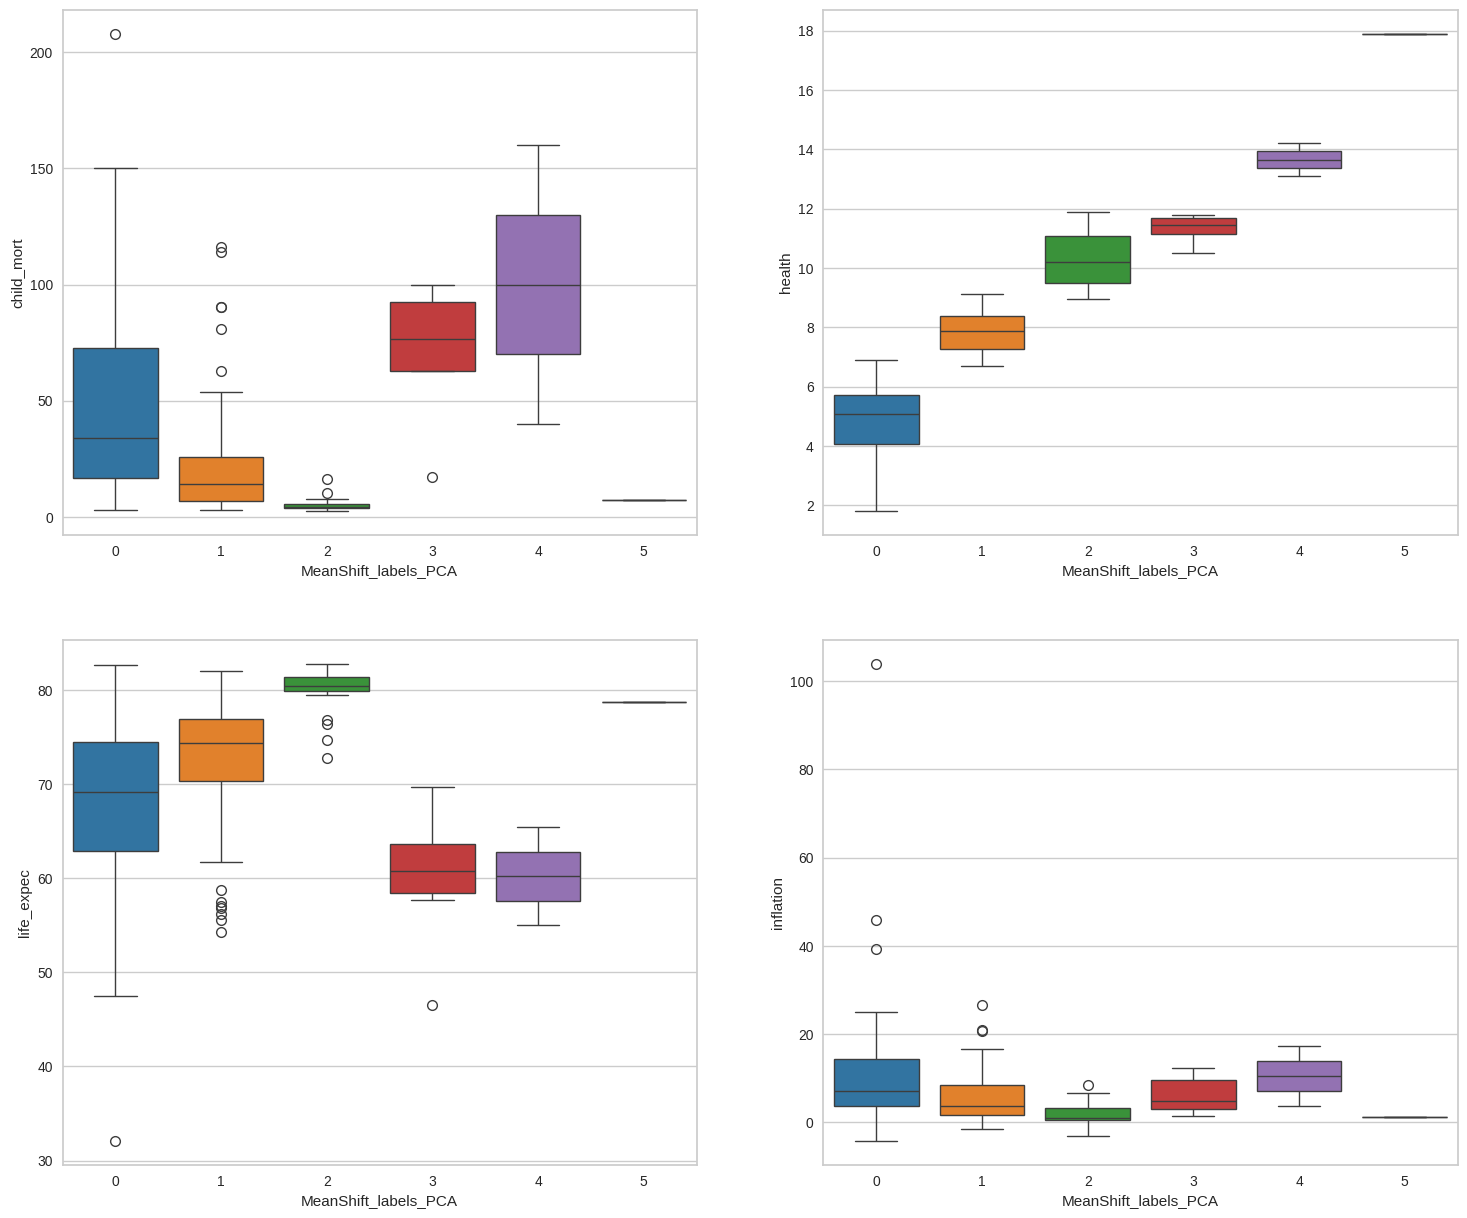

In [179]:
compared_features = ["child_mort", "health", "life_expec", "inflation"]
num_clusters = data_copy['MeanShift_labels_PCA'].nunique()
palette = sns.color_palette("tab10", num_clusters) 
fig , axes = plt.subplots(2,2,figsize= (18,15))
axes = axes.flatten()
for idx , column in enumerate(compared_features):
    ax = axes[idx]

    sns.boxplot(data=data_copy, x='MeanShift_labels_PCA', y=column, ax=ax, palette=palette)

| Cluster        | Need for Support         | Summary                                            |
| -------------- | ------------------------ | -------------------------------------------------- |
| **0 (Blue)**   | 🟡 **May need help**     | Mixed metrics, likely transitional economies       |
| **1 (Orange)** | ✅ **Does not need help** | Strong across all health & economy indicators      |
| **2 (Green)**  | ✅ **Does not need help** | Elite performers                                   |
| **3 (Red)**    | 🔴 **Needs help**        | High mortality, low spending, poor life expectancy |
| **4 (Purple)** | 🔴 **Needs help**        | Similar to Cluster 3 with slightly better health   |
| **5 (Dark)**   | ✅ **Does not need help** | Outlier nation with perfect scores                 |
